<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/42_Lite_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🌝 Задание Lite

Макс 10 баллов

Используйте готовый ноутбук с занятия, генерируйте рукописные цифры

Запустите базовую генеративную сеть, с Dense генератором и дискриминатором

Поменяйте размер внутреннего пространства генератора с 100 на 10 и 1000, сравните результаты.

Сделайте свёрточный генератор, сравните результаты с полносвязным генератором

Сделайте возможность запускать обучение с разными batch_size для генератора и дискриминатора, попробуйте запустить с batch_size 128 для дискриминатора и 256 для генератора, сравните результат с равными batch_size по 128.


In [ ]:
# Подключение библиотек
from keras.datasets import mnist, cifar10 # Mnist - набор рукописных цифр, cifar10 - изображения объектов 1-ти классов
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply, Conv2DTranspose # Базовые слои keras
from keras.layers.advanced_activations import LeakyReLU # LeakyReLU - функция активации
from keras.layers.convolutional import UpSampling2D, Conv2D # Сверточные слои keras
from keras.models import Sequential, Model # Формат модели keras
from tensorflow.keras.optimizers import Adam # Оптимизатор 

import matplotlib.pyplot as plt # Отображение графиков

import numpy as np # Numpy массивы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Параметры и функции

In [ ]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [ ]:
!mkdir images # Создаем каталог 'images'

In [ ]:
def create_generator(): # Функция создания генератора
  generator = Sequential() # Инициализируем модель generator

  generator.add(Dense(256, input_dim=latent_dim)) # Добавляем Dense-слой на 256 нейронов (размерность входных данных = latent_dim)
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(1024)) # Добавляем Dense-слой на 1024 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(np.prod(img_shape), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
  generator.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))

  noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  img = generator(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

  generator = Model(noise, img) # создаем модель generator (входные данные: noise, выходные данные: img)

  return generator # Функция возвращаем generator

In [ ]:
gen = create_generator()
gen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         1493520   
                                                                 
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


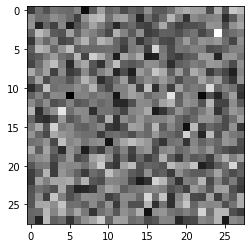

In [ ]:
input1 = np.random.random(size=(1, 100))
plt.imshow(input1, cmap='gray')
plt.axis('off')
plt.show()
predict_gen = gen.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
def create_discriminator(): # Функция создания дискриминатора
  discriminator = Sequential() # Инициализируем модель discriminator

  discriminator.add(Flatten(input_shape=img_shape)) # Создаем слой Flatten (размерность входных данных = (img_rows, img_cols, channels), размерность выходных данных = img_rows * img_cols * channels )
  discriminator.add(Dense(512))  # Добавляем Dense-слой на 512 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  discriminator = Model(img, validity) # Создаем модель discriminator (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  
  discriminator.trainable = False  # Замораживаем обучение дискриматора 

  return discriminator # Функция возвращает discriminator

In [ ]:
dis = create_discriminator()
dis.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


In [ ]:
predict_dis = dis.predict(predict_gen)
print(predict_dis)

[[0.4595871]]


In [ ]:
batch_size = 128 # Размер batch_size

(X_train, _), (_, _) = mnist.load_data() # Загружаем в X_train изображения рукописных цифр из mnist

X_train = X_train / 127.5 - 1. # Трансофрмируем значение в диапазон от -1 до 1
X_train = np.expand_dims(X_train, axis=3) # Добавляем третью размерность для X_train ((28,28) => (28,28,1))

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def sample_images(epoch, gen): # Функция печати изображений
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise) # Предиктим картинку с помощью входной переменной gen
  
  #gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r): 
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

In [ ]:
def train(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения   
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size

  z = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем выводить текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs): 
    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    imgs = X_train[idx] # В переменную imgs записываем значение из X_train с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений
    
    gen_imgs = generator.predict(noise) # Предиктим картинку с помощью входной переменной generator
      
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = combined.train_on_batch(noise, valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))
    
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
        
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): 
        sample_images(epoch, generator) # Вызываем функцию sample_images для печати изображений
  
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

0 [D loss: 1.021552, acc.: 22.66%] [G loss: 0.869737]


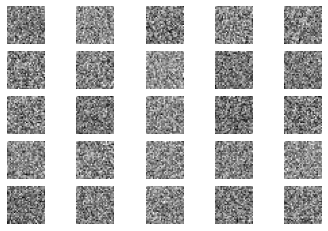

1 [D loss: 0.415039, acc.: 85.16%] [G loss: 0.830509]
2 [D loss: 0.351318, acc.: 86.33%] [G loss: 0.848294]
3 [D loss: 0.333922, acc.: 86.72%] [G loss: 0.870770]
4 [D loss: 0.327044, acc.: 87.89%] [G loss: 0.905647]
5 [D loss: 0.312022, acc.: 90.62%] [G loss: 0.974328]
6 [D loss: 0.292633, acc.: 92.97%] [G loss: 1.086502]
7 [D loss: 0.255775, acc.: 97.66%] [G loss: 1.197529]
8 [D loss: 0.217643, acc.: 98.83%] [G loss: 1.305039]
9 [D loss: 0.184333, acc.: 99.61%] [G loss: 1.464173]
10 [D loss: 0.177366, acc.: 99.22%] [G loss: 1.578479]
11 [D loss: 0.144327, acc.: 100.00%] [G loss: 1.728276]
12 [D loss: 0.134851, acc.: 100.00%] [G loss: 1.803586]
13 [D loss: 0.111788, acc.: 100.00%] [G loss: 1.954335]
14 [D loss: 0.106425, acc.: 100.00%] [G loss: 2.040466]
15 [D loss: 0.087365, acc.: 100.00%] [G loss: 2.189362]
16 [D loss: 0.085274, acc.: 100.00%] [G loss: 2.237840]
17 [D loss: 0.081986, acc.: 100.00%] [G loss: 2.317662]
18 [D loss: 0.070619, acc.: 100.00%] [G loss: 2.414608]
19 [D loss:

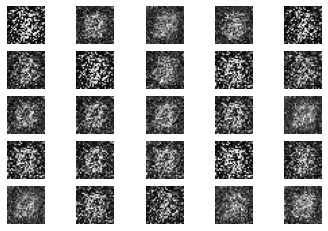

201 [D loss: 0.441947, acc.: 70.70%] [G loss: 1.983328]
202 [D loss: 0.503687, acc.: 73.83%] [G loss: 1.987565]
203 [D loss: 0.644028, acc.: 58.59%] [G loss: 1.539500]
204 [D loss: 0.468380, acc.: 71.88%] [G loss: 1.896161]
205 [D loss: 0.781457, acc.: 49.61%] [G loss: 1.067698]
206 [D loss: 0.446587, acc.: 71.09%] [G loss: 1.933108]
207 [D loss: 0.637069, acc.: 62.11%] [G loss: 1.467076]
208 [D loss: 0.521453, acc.: 66.41%] [G loss: 1.707369]
209 [D loss: 0.541371, acc.: 68.75%] [G loss: 1.782556]
210 [D loss: 0.632371, acc.: 61.72%] [G loss: 1.558147]
211 [D loss: 0.585096, acc.: 60.94%] [G loss: 1.651640]
212 [D loss: 0.596409, acc.: 66.02%] [G loss: 1.609525]
213 [D loss: 0.588898, acc.: 65.62%] [G loss: 1.576026]
214 [D loss: 0.670816, acc.: 55.08%] [G loss: 1.372379]
215 [D loss: 0.580487, acc.: 64.06%] [G loss: 1.610398]
216 [D loss: 0.644010, acc.: 61.72%] [G loss: 1.465162]
217 [D loss: 0.663337, acc.: 55.08%] [G loss: 1.376194]
218 [D loss: 0.620078, acc.: 57.81%] [G loss: 1.

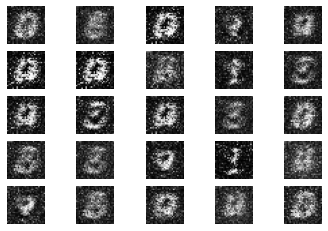

401 [D loss: 0.661316, acc.: 49.61%] [G loss: 0.649732]
402 [D loss: 0.644035, acc.: 51.17%] [G loss: 0.665214]
403 [D loss: 0.641288, acc.: 50.78%] [G loss: 0.662955]
404 [D loss: 0.644383, acc.: 53.91%] [G loss: 0.661046]
405 [D loss: 0.655699, acc.: 51.56%] [G loss: 0.670195]
406 [D loss: 0.646909, acc.: 53.12%] [G loss: 0.693119]
407 [D loss: 0.648283, acc.: 50.39%] [G loss: 0.694657]
408 [D loss: 0.649743, acc.: 50.00%] [G loss: 0.682994]
409 [D loss: 0.641790, acc.: 50.78%] [G loss: 0.676356]
410 [D loss: 0.650648, acc.: 50.78%] [G loss: 0.672693]
411 [D loss: 0.641517, acc.: 51.95%] [G loss: 0.683963]
412 [D loss: 0.646717, acc.: 51.17%] [G loss: 0.683320]
413 [D loss: 0.649370, acc.: 49.61%] [G loss: 0.674805]
414 [D loss: 0.629458, acc.: 50.78%] [G loss: 0.683383]
415 [D loss: 0.635150, acc.: 51.17%] [G loss: 0.685294]
416 [D loss: 0.629663, acc.: 53.12%] [G loss: 0.695631]
417 [D loss: 0.639191, acc.: 49.22%] [G loss: 0.694580]
418 [D loss: 0.636017, acc.: 51.56%] [G loss: 0.

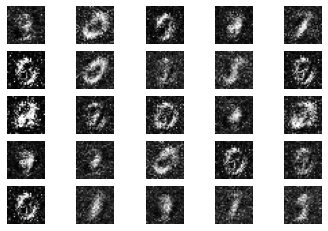

601 [D loss: 0.633472, acc.: 58.98%] [G loss: 0.744029]
602 [D loss: 0.620056, acc.: 62.11%] [G loss: 0.750367]
603 [D loss: 0.625893, acc.: 61.72%] [G loss: 0.745102]
604 [D loss: 0.629325, acc.: 60.55%] [G loss: 0.743496]
605 [D loss: 0.621139, acc.: 63.67%] [G loss: 0.748760]
606 [D loss: 0.620014, acc.: 62.50%] [G loss: 0.749990]
607 [D loss: 0.608598, acc.: 69.14%] [G loss: 0.759313]
608 [D loss: 0.620586, acc.: 64.45%] [G loss: 0.749577]
609 [D loss: 0.607506, acc.: 67.19%] [G loss: 0.761005]
610 [D loss: 0.601867, acc.: 71.09%] [G loss: 0.762158]
611 [D loss: 0.609395, acc.: 73.44%] [G loss: 0.758957]
612 [D loss: 0.606650, acc.: 70.31%] [G loss: 0.765039]
613 [D loss: 0.603615, acc.: 71.09%] [G loss: 0.769342]
614 [D loss: 0.602401, acc.: 75.39%] [G loss: 0.770722]
615 [D loss: 0.612178, acc.: 69.53%] [G loss: 0.770715]
616 [D loss: 0.610886, acc.: 71.48%] [G loss: 0.773412]
617 [D loss: 0.611363, acc.: 74.61%] [G loss: 0.770542]
618 [D loss: 0.607559, acc.: 69.14%] [G loss: 0.

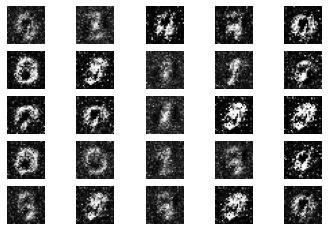

801 [D loss: 0.611581, acc.: 67.19%] [G loss: 0.895865]
802 [D loss: 0.603491, acc.: 74.61%] [G loss: 0.896729]
803 [D loss: 0.634273, acc.: 69.53%] [G loss: 0.857984]
804 [D loss: 0.603959, acc.: 71.48%] [G loss: 0.877527]
805 [D loss: 0.610677, acc.: 77.34%] [G loss: 0.929247]
806 [D loss: 0.589657, acc.: 77.73%] [G loss: 0.948318]
807 [D loss: 0.597238, acc.: 70.70%] [G loss: 0.926501]
808 [D loss: 0.590799, acc.: 76.56%] [G loss: 0.908083]
809 [D loss: 0.601423, acc.: 69.14%] [G loss: 0.905353]
810 [D loss: 0.599013, acc.: 70.31%] [G loss: 0.926338]
811 [D loss: 0.606711, acc.: 72.66%] [G loss: 0.923584]
812 [D loss: 0.604563, acc.: 72.66%] [G loss: 0.933279]
813 [D loss: 0.590070, acc.: 80.47%] [G loss: 0.972078]
814 [D loss: 0.615985, acc.: 72.66%] [G loss: 0.964127]
815 [D loss: 0.606017, acc.: 73.83%] [G loss: 0.971340]
816 [D loss: 0.616186, acc.: 67.97%] [G loss: 0.931288]
817 [D loss: 0.597019, acc.: 70.70%] [G loss: 0.940374]
818 [D loss: 0.611344, acc.: 68.36%] [G loss: 0.

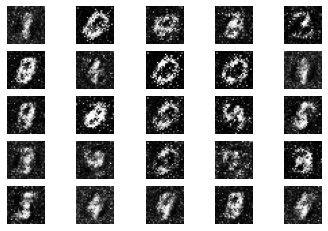

1001 [D loss: 0.592050, acc.: 71.88%] [G loss: 0.958902]
1002 [D loss: 0.565609, acc.: 77.73%] [G loss: 0.981927]
1003 [D loss: 0.601600, acc.: 75.39%] [G loss: 0.945663]
1004 [D loss: 0.590543, acc.: 69.92%] [G loss: 0.958332]
1005 [D loss: 0.558393, acc.: 77.73%] [G loss: 1.010480]
1006 [D loss: 0.551312, acc.: 80.47%] [G loss: 1.047783]
1007 [D loss: 0.581451, acc.: 77.73%] [G loss: 1.014837]
1008 [D loss: 0.595694, acc.: 66.80%] [G loss: 1.010598]
1009 [D loss: 0.604677, acc.: 64.84%] [G loss: 0.975375]
1010 [D loss: 0.656233, acc.: 57.03%] [G loss: 0.980222]
1011 [D loss: 0.600863, acc.: 68.75%] [G loss: 1.013660]
1012 [D loss: 0.631677, acc.: 65.23%] [G loss: 0.997593]
1013 [D loss: 0.603248, acc.: 68.75%] [G loss: 0.999026]
1014 [D loss: 0.627909, acc.: 66.02%] [G loss: 0.995390]
1015 [D loss: 0.599517, acc.: 71.48%] [G loss: 1.034698]
1016 [D loss: 0.594629, acc.: 70.31%] [G loss: 1.014205]
1017 [D loss: 0.631332, acc.: 66.02%] [G loss: 1.017936]
1018 [D loss: 0.575809, acc.: 7

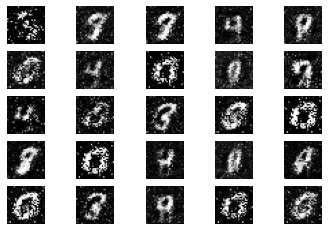

1201 [D loss: 0.556602, acc.: 79.30%] [G loss: 1.045920]
1202 [D loss: 0.539321, acc.: 79.30%] [G loss: 1.047268]
1203 [D loss: 0.569566, acc.: 75.78%] [G loss: 1.020654]
1204 [D loss: 0.563999, acc.: 76.56%] [G loss: 1.010438]
1205 [D loss: 0.572949, acc.: 76.56%] [G loss: 1.035561]
1206 [D loss: 0.530544, acc.: 80.86%] [G loss: 1.091587]
1207 [D loss: 0.561883, acc.: 78.12%] [G loss: 1.038256]
1208 [D loss: 0.577410, acc.: 75.39%] [G loss: 1.023380]
1209 [D loss: 0.562965, acc.: 74.61%] [G loss: 1.064269]
1210 [D loss: 0.568088, acc.: 76.56%] [G loss: 1.056269]
1211 [D loss: 0.561808, acc.: 75.00%] [G loss: 1.029412]
1212 [D loss: 0.564271, acc.: 75.78%] [G loss: 1.054915]
1213 [D loss: 0.548535, acc.: 78.91%] [G loss: 1.064243]
1214 [D loss: 0.558808, acc.: 79.69%] [G loss: 1.087959]
1215 [D loss: 0.597604, acc.: 69.53%] [G loss: 1.010785]
1216 [D loss: 0.581526, acc.: 71.88%] [G loss: 1.029485]
1217 [D loss: 0.596382, acc.: 74.61%] [G loss: 1.024112]
1218 [D loss: 0.561475, acc.: 7

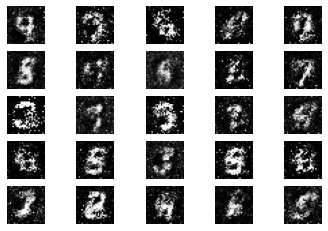

1401 [D loss: 0.561814, acc.: 73.44%] [G loss: 1.041852]
1402 [D loss: 0.576940, acc.: 72.66%] [G loss: 1.020706]
1403 [D loss: 0.583785, acc.: 73.05%] [G loss: 1.011892]
1404 [D loss: 0.588553, acc.: 67.97%] [G loss: 1.004166]
1405 [D loss: 0.540288, acc.: 76.56%] [G loss: 1.053055]
1406 [D loss: 0.560113, acc.: 73.44%] [G loss: 1.042861]
1407 [D loss: 0.559038, acc.: 70.70%] [G loss: 1.056795]
1408 [D loss: 0.538217, acc.: 77.34%] [G loss: 1.073797]
1409 [D loss: 0.568309, acc.: 69.92%] [G loss: 1.050749]
1410 [D loss: 0.554032, acc.: 74.22%] [G loss: 1.079742]
1411 [D loss: 0.547389, acc.: 74.61%] [G loss: 1.060181]
1412 [D loss: 0.554088, acc.: 75.00%] [G loss: 1.071081]
1413 [D loss: 0.579566, acc.: 71.88%] [G loss: 1.048225]
1414 [D loss: 0.590946, acc.: 68.36%] [G loss: 0.995932]
1415 [D loss: 0.546407, acc.: 74.61%] [G loss: 1.028354]
1416 [D loss: 0.553130, acc.: 75.00%] [G loss: 1.044711]
1417 [D loss: 0.575178, acc.: 69.53%] [G loss: 1.026730]
1418 [D loss: 0.570686, acc.: 6

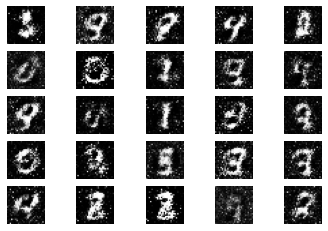

1601 [D loss: 0.592572, acc.: 68.75%] [G loss: 1.050490]
1602 [D loss: 0.591157, acc.: 70.31%] [G loss: 1.037427]
1603 [D loss: 0.613835, acc.: 69.14%] [G loss: 0.982096]
1604 [D loss: 0.596872, acc.: 67.19%] [G loss: 0.987743]
1605 [D loss: 0.564266, acc.: 73.05%] [G loss: 1.039052]
1606 [D loss: 0.564050, acc.: 74.61%] [G loss: 1.033762]
1607 [D loss: 0.582285, acc.: 68.36%] [G loss: 0.997350]
1608 [D loss: 0.601990, acc.: 66.41%] [G loss: 1.028708]
1609 [D loss: 0.589407, acc.: 72.27%] [G loss: 1.044612]
1610 [D loss: 0.598247, acc.: 66.41%] [G loss: 1.005057]
1611 [D loss: 0.591600, acc.: 71.09%] [G loss: 1.008941]
1612 [D loss: 0.567697, acc.: 74.61%] [G loss: 1.025354]
1613 [D loss: 0.592398, acc.: 69.14%] [G loss: 0.993172]
1614 [D loss: 0.585474, acc.: 69.53%] [G loss: 1.025935]
1615 [D loss: 0.596406, acc.: 65.62%] [G loss: 0.997739]
1616 [D loss: 0.593942, acc.: 67.58%] [G loss: 1.058531]
1617 [D loss: 0.599528, acc.: 67.58%] [G loss: 1.018071]
1618 [D loss: 0.605544, acc.: 6

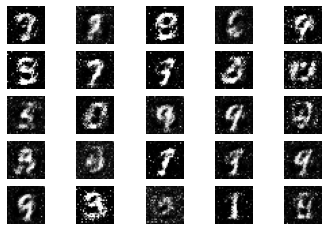

1801 [D loss: 0.605858, acc.: 67.58%] [G loss: 0.998181]
1802 [D loss: 0.586476, acc.: 71.09%] [G loss: 1.019719]
1803 [D loss: 0.623564, acc.: 69.14%] [G loss: 0.993979]
1804 [D loss: 0.601722, acc.: 68.36%] [G loss: 0.970757]
1805 [D loss: 0.582477, acc.: 70.70%] [G loss: 0.973353]
1806 [D loss: 0.581276, acc.: 73.44%] [G loss: 0.998025]
1807 [D loss: 0.566682, acc.: 75.78%] [G loss: 1.003685]
1808 [D loss: 0.614591, acc.: 68.75%] [G loss: 0.966783]
1809 [D loss: 0.583252, acc.: 71.48%] [G loss: 0.938748]
1810 [D loss: 0.577659, acc.: 72.27%] [G loss: 0.949747]
1811 [D loss: 0.587970, acc.: 71.09%] [G loss: 0.945775]
1812 [D loss: 0.616597, acc.: 66.80%] [G loss: 0.911925]
1813 [D loss: 0.563809, acc.: 76.56%] [G loss: 0.989867]
1814 [D loss: 0.595965, acc.: 74.61%] [G loss: 0.967703]
1815 [D loss: 0.589868, acc.: 73.05%] [G loss: 0.986711]
1816 [D loss: 0.588631, acc.: 67.97%] [G loss: 0.996509]
1817 [D loss: 0.590083, acc.: 71.48%] [G loss: 0.964149]
1818 [D loss: 0.612450, acc.: 6

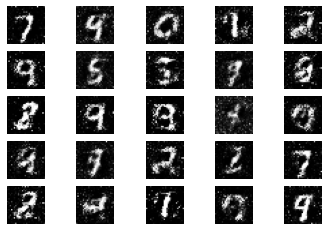

2001 [D loss: 0.604880, acc.: 69.92%] [G loss: 0.946709]
2002 [D loss: 0.584203, acc.: 70.31%] [G loss: 0.955106]
2003 [D loss: 0.593197, acc.: 71.09%] [G loss: 0.969743]
2004 [D loss: 0.601350, acc.: 71.48%] [G loss: 0.970622]
2005 [D loss: 0.605200, acc.: 68.36%] [G loss: 0.962179]
2006 [D loss: 0.609116, acc.: 71.09%] [G loss: 0.920224]
2007 [D loss: 0.611860, acc.: 66.41%] [G loss: 0.953199]
2008 [D loss: 0.607832, acc.: 66.80%] [G loss: 0.920920]
2009 [D loss: 0.606938, acc.: 67.19%] [G loss: 0.948065]
2010 [D loss: 0.599362, acc.: 69.53%] [G loss: 0.938311]
2011 [D loss: 0.620813, acc.: 68.36%] [G loss: 0.946670]
2012 [D loss: 0.603368, acc.: 67.58%] [G loss: 0.944286]
2013 [D loss: 0.567418, acc.: 75.00%] [G loss: 0.987561]
2014 [D loss: 0.607433, acc.: 65.62%] [G loss: 0.946897]
2015 [D loss: 0.594496, acc.: 69.14%] [G loss: 0.966240]
2016 [D loss: 0.615275, acc.: 64.06%] [G loss: 0.929407]
2017 [D loss: 0.630401, acc.: 65.23%] [G loss: 0.926774]
2018 [D loss: 0.587823, acc.: 7

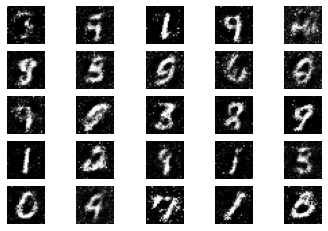

2201 [D loss: 0.585275, acc.: 74.61%] [G loss: 0.935771]
2202 [D loss: 0.607606, acc.: 70.31%] [G loss: 0.934558]
2203 [D loss: 0.635481, acc.: 66.41%] [G loss: 0.881911]
2204 [D loss: 0.609635, acc.: 67.19%] [G loss: 0.923699]
2205 [D loss: 0.575619, acc.: 76.56%] [G loss: 0.942880]
2206 [D loss: 0.613396, acc.: 66.02%] [G loss: 0.959461]
2207 [D loss: 0.635368, acc.: 60.94%] [G loss: 0.933518]
2208 [D loss: 0.615418, acc.: 69.92%] [G loss: 0.946264]
2209 [D loss: 0.618725, acc.: 67.58%] [G loss: 0.912914]
2210 [D loss: 0.629074, acc.: 63.28%] [G loss: 0.900618]
2211 [D loss: 0.619437, acc.: 69.92%] [G loss: 0.928856]
2212 [D loss: 0.634595, acc.: 66.80%] [G loss: 0.910197]
2213 [D loss: 0.618323, acc.: 66.80%] [G loss: 0.941389]
2214 [D loss: 0.609619, acc.: 71.09%] [G loss: 0.928602]
2215 [D loss: 0.639659, acc.: 63.67%] [G loss: 0.903961]
2216 [D loss: 0.620402, acc.: 69.53%] [G loss: 0.886970]
2217 [D loss: 0.612851, acc.: 73.05%] [G loss: 0.896465]
2218 [D loss: 0.608056, acc.: 6

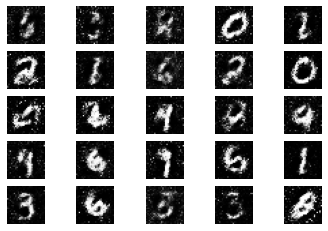

2401 [D loss: 0.623716, acc.: 64.45%] [G loss: 0.910486]
2402 [D loss: 0.623969, acc.: 67.97%] [G loss: 0.934992]
2403 [D loss: 0.645640, acc.: 66.02%] [G loss: 0.910825]
2404 [D loss: 0.632850, acc.: 62.89%] [G loss: 0.898462]
2405 [D loss: 0.645916, acc.: 60.94%] [G loss: 0.885221]
2406 [D loss: 0.644215, acc.: 63.28%] [G loss: 0.922141]
2407 [D loss: 0.650061, acc.: 59.77%] [G loss: 0.891913]
2408 [D loss: 0.634966, acc.: 62.50%] [G loss: 0.870415]
2409 [D loss: 0.616939, acc.: 65.23%] [G loss: 0.939357]
2410 [D loss: 0.642411, acc.: 62.89%] [G loss: 0.890082]
2411 [D loss: 0.626034, acc.: 66.02%] [G loss: 0.906737]
2412 [D loss: 0.593188, acc.: 72.27%] [G loss: 0.929879]
2413 [D loss: 0.660279, acc.: 60.94%] [G loss: 0.895512]
2414 [D loss: 0.622351, acc.: 67.58%] [G loss: 0.898213]
2415 [D loss: 0.608263, acc.: 69.53%] [G loss: 0.915372]
2416 [D loss: 0.624198, acc.: 70.70%] [G loss: 0.913746]
2417 [D loss: 0.629477, acc.: 69.92%] [G loss: 0.913909]
2418 [D loss: 0.632972, acc.: 6

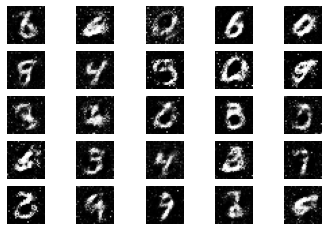

2601 [D loss: 0.614895, acc.: 67.19%] [G loss: 0.911900]
2602 [D loss: 0.640792, acc.: 62.50%] [G loss: 0.883747]
2603 [D loss: 0.627204, acc.: 64.45%] [G loss: 0.902044]
2604 [D loss: 0.609191, acc.: 69.92%] [G loss: 0.925744]
2605 [D loss: 0.646418, acc.: 66.41%] [G loss: 0.889774]
2606 [D loss: 0.633922, acc.: 66.80%] [G loss: 0.890911]
2607 [D loss: 0.638033, acc.: 65.62%] [G loss: 0.898416]
2608 [D loss: 0.596533, acc.: 72.27%] [G loss: 0.918239]
2609 [D loss: 0.626282, acc.: 66.41%] [G loss: 0.898484]
2610 [D loss: 0.628076, acc.: 67.97%] [G loss: 0.888785]
2611 [D loss: 0.634341, acc.: 67.19%] [G loss: 0.899834]
2612 [D loss: 0.611806, acc.: 67.97%] [G loss: 0.895296]
2613 [D loss: 0.641760, acc.: 64.45%] [G loss: 0.852776]
2614 [D loss: 0.648080, acc.: 65.62%] [G loss: 0.891909]
2615 [D loss: 0.652859, acc.: 61.72%] [G loss: 0.870832]
2616 [D loss: 0.628527, acc.: 65.62%] [G loss: 0.899755]
2617 [D loss: 0.603508, acc.: 73.05%] [G loss: 0.896302]
2618 [D loss: 0.619024, acc.: 6

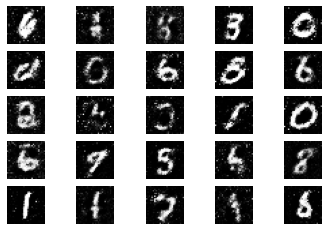

2801 [D loss: 0.601658, acc.: 76.17%] [G loss: 0.882427]
2802 [D loss: 0.657243, acc.: 60.55%] [G loss: 0.908736]
2803 [D loss: 0.601094, acc.: 69.92%] [G loss: 0.948724]
2804 [D loss: 0.627568, acc.: 69.53%] [G loss: 0.896296]
2805 [D loss: 0.612355, acc.: 67.97%] [G loss: 0.910869]
2806 [D loss: 0.628607, acc.: 66.02%] [G loss: 0.891288]
2807 [D loss: 0.591147, acc.: 73.44%] [G loss: 0.911447]
2808 [D loss: 0.595816, acc.: 72.66%] [G loss: 0.924156]
2809 [D loss: 0.629270, acc.: 64.06%] [G loss: 0.896514]
2810 [D loss: 0.645253, acc.: 64.45%] [G loss: 0.868963]
2811 [D loss: 0.612628, acc.: 69.53%] [G loss: 0.915652]
2812 [D loss: 0.621119, acc.: 65.23%] [G loss: 0.913605]
2813 [D loss: 0.613241, acc.: 68.75%] [G loss: 0.912233]
2814 [D loss: 0.636884, acc.: 66.41%] [G loss: 0.890415]
2815 [D loss: 0.649490, acc.: 63.28%] [G loss: 0.872055]
2816 [D loss: 0.615968, acc.: 68.36%] [G loss: 0.915073]
2817 [D loss: 0.608467, acc.: 71.48%] [G loss: 0.904356]
2818 [D loss: 0.639429, acc.: 6

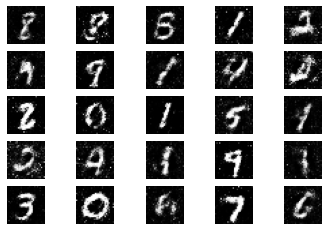

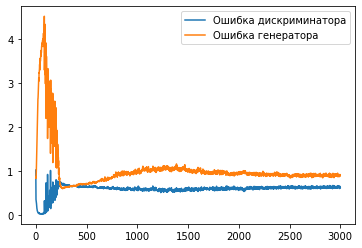

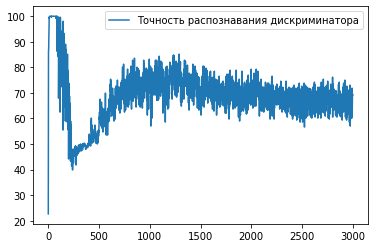

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 3000) # Вызываем функцию train с параметрами, generator, discriminator, 3000 (3000 - количество эпох)

In [ ]:
# generator.save_weights('drive/My Drive/generator.h5')
generator.load_weights('drive/My Drive/generator.h5')

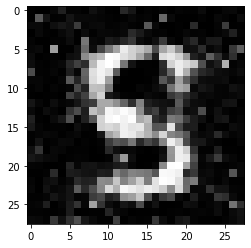

In [ ]:
input1 = np.random.random(size=(1, 100))
predict_gen = generator.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

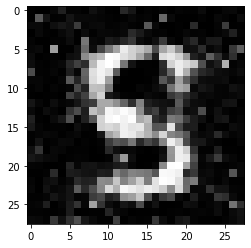

In [ ]:
# generator.load_weights('drive/My Drive/generator.h5')
predict_gen = generator.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

# Размер внутреннего пространства генератора с 100 на 1000
Результат: 2999 [D loss: 0.629420, acc.: 69.92%] [G loss: 0.854295]

In [ ]:
latent_dim = 1000 # Размерность скрытого пространства

0 [D loss: 1.112734, acc.: 10.94%] [G loss: 0.879801]


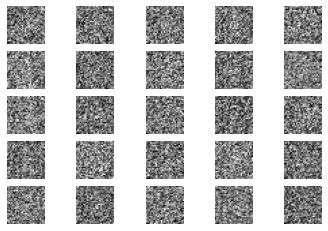

1 [D loss: 1.322599, acc.: 58.20%] [G loss: 2.228272]
2 [D loss: 0.062348, acc.: 97.66%] [G loss: 3.105204]
3 [D loss: 10.310447, acc.: 9.38%] [G loss: 4.032086]
4 [D loss: 0.843972, acc.: 80.47%] [G loss: 4.241482]
5 [D loss: 1.299707, acc.: 77.73%] [G loss: 5.200448]
6 [D loss: 1.220921, acc.: 75.39%] [G loss: 4.285680]
7 [D loss: 0.556694, acc.: 83.59%] [G loss: 3.739462]
8 [D loss: 1.086131, acc.: 75.78%] [G loss: 4.104446]
9 [D loss: 0.817689, acc.: 76.56%] [G loss: 3.777294]
10 [D loss: 0.404165, acc.: 82.81%] [G loss: 3.848719]
11 [D loss: 0.410862, acc.: 83.59%] [G loss: 3.999362]
12 [D loss: 0.098590, acc.: 96.09%] [G loss: 3.874389]
13 [D loss: 0.099009, acc.: 95.31%] [G loss: 3.907690]
14 [D loss: 0.054729, acc.: 98.83%] [G loss: 3.876092]
15 [D loss: 0.073849, acc.: 96.48%] [G loss: 3.817253]
16 [D loss: 0.076568, acc.: 97.27%] [G loss: 3.693866]
17 [D loss: 0.043924, acc.: 99.22%] [G loss: 3.600521]
18 [D loss: 0.094113, acc.: 95.31%] [G loss: 3.619254]
19 [D loss: 0.05697

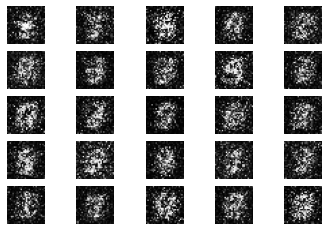

201 [D loss: 0.770098, acc.: 36.72%] [G loss: 0.869340]
202 [D loss: 0.822994, acc.: 29.69%] [G loss: 0.850278]
203 [D loss: 0.788298, acc.: 33.98%] [G loss: 0.861915]
204 [D loss: 0.797622, acc.: 32.42%] [G loss: 0.864711]
205 [D loss: 0.796324, acc.: 31.25%] [G loss: 0.844549]
206 [D loss: 0.773295, acc.: 35.55%] [G loss: 0.863432]
207 [D loss: 0.802472, acc.: 29.69%] [G loss: 0.853090]
208 [D loss: 0.798333, acc.: 30.08%] [G loss: 0.811685]
209 [D loss: 0.799052, acc.: 35.94%] [G loss: 0.837810]
210 [D loss: 0.782749, acc.: 31.25%] [G loss: 0.862874]
211 [D loss: 0.793957, acc.: 30.08%] [G loss: 0.836505]
212 [D loss: 0.771196, acc.: 33.59%] [G loss: 0.858032]
213 [D loss: 0.768808, acc.: 32.81%] [G loss: 0.835755]
214 [D loss: 0.794394, acc.: 31.64%] [G loss: 0.837198]
215 [D loss: 0.769451, acc.: 35.16%] [G loss: 0.846422]
216 [D loss: 0.779258, acc.: 32.03%] [G loss: 0.823657]
217 [D loss: 0.761683, acc.: 37.89%] [G loss: 0.833707]
218 [D loss: 0.777620, acc.: 32.42%] [G loss: 0.

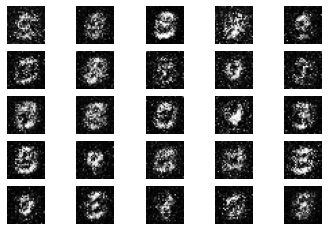

401 [D loss: 0.717093, acc.: 39.84%] [G loss: 0.721758]
402 [D loss: 0.715627, acc.: 38.67%] [G loss: 0.719141]
403 [D loss: 0.712251, acc.: 39.45%] [G loss: 0.720291]
404 [D loss: 0.705571, acc.: 39.06%] [G loss: 0.732518]
405 [D loss: 0.709630, acc.: 39.84%] [G loss: 0.731436]
406 [D loss: 0.711555, acc.: 38.67%] [G loss: 0.729848]
407 [D loss: 0.711408, acc.: 34.77%] [G loss: 0.729291]
408 [D loss: 0.713615, acc.: 35.94%] [G loss: 0.723310]
409 [D loss: 0.709475, acc.: 40.23%] [G loss: 0.724606]
410 [D loss: 0.705811, acc.: 41.02%] [G loss: 0.729633]
411 [D loss: 0.717901, acc.: 36.33%] [G loss: 0.722086]
412 [D loss: 0.711056, acc.: 37.50%] [G loss: 0.725963]
413 [D loss: 0.711922, acc.: 37.89%] [G loss: 0.724318]
414 [D loss: 0.706457, acc.: 41.80%] [G loss: 0.728749]
415 [D loss: 0.709339, acc.: 39.84%] [G loss: 0.728290]
416 [D loss: 0.709882, acc.: 40.62%] [G loss: 0.728183]
417 [D loss: 0.717288, acc.: 37.11%] [G loss: 0.721989]
418 [D loss: 0.708123, acc.: 36.72%] [G loss: 0.

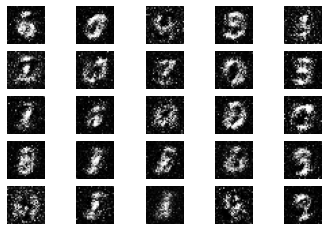

601 [D loss: 0.694073, acc.: 44.92%] [G loss: 0.722641]
602 [D loss: 0.693940, acc.: 43.36%] [G loss: 0.724963]
603 [D loss: 0.695651, acc.: 41.02%] [G loss: 0.726266]
604 [D loss: 0.700860, acc.: 42.97%] [G loss: 0.728758]
605 [D loss: 0.696376, acc.: 46.09%] [G loss: 0.726161]
606 [D loss: 0.695752, acc.: 44.14%] [G loss: 0.718017]
607 [D loss: 0.688584, acc.: 46.48%] [G loss: 0.727811]
608 [D loss: 0.698677, acc.: 41.41%] [G loss: 0.729671]
609 [D loss: 0.700209, acc.: 42.58%] [G loss: 0.728090]
610 [D loss: 0.693820, acc.: 46.48%] [G loss: 0.732214]
611 [D loss: 0.695572, acc.: 43.75%] [G loss: 0.730272]
612 [D loss: 0.691828, acc.: 45.31%] [G loss: 0.734431]
613 [D loss: 0.687389, acc.: 48.44%] [G loss: 0.730510]
614 [D loss: 0.703549, acc.: 42.58%] [G loss: 0.720964]
615 [D loss: 0.698690, acc.: 44.14%] [G loss: 0.722512]
616 [D loss: 0.690136, acc.: 50.78%] [G loss: 0.730082]
617 [D loss: 0.700639, acc.: 43.36%] [G loss: 0.726023]
618 [D loss: 0.694938, acc.: 49.61%] [G loss: 0.

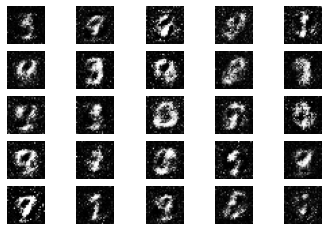

801 [D loss: 0.679872, acc.: 54.30%] [G loss: 0.747295]
802 [D loss: 0.686643, acc.: 51.56%] [G loss: 0.734143]
803 [D loss: 0.687511, acc.: 49.22%] [G loss: 0.730887]
804 [D loss: 0.689493, acc.: 50.78%] [G loss: 0.733020]
805 [D loss: 0.687252, acc.: 53.91%] [G loss: 0.740865]
806 [D loss: 0.690592, acc.: 47.27%] [G loss: 0.732654]
807 [D loss: 0.687298, acc.: 48.05%] [G loss: 0.740473]
808 [D loss: 0.688654, acc.: 46.48%] [G loss: 0.729399]
809 [D loss: 0.689261, acc.: 45.31%] [G loss: 0.736818]
810 [D loss: 0.690966, acc.: 49.61%] [G loss: 0.734199]
811 [D loss: 0.691518, acc.: 50.78%] [G loss: 0.726871]
812 [D loss: 0.681606, acc.: 52.34%] [G loss: 0.733153]
813 [D loss: 0.683431, acc.: 56.64%] [G loss: 0.735249]
814 [D loss: 0.691483, acc.: 50.39%] [G loss: 0.730675]
815 [D loss: 0.680988, acc.: 54.69%] [G loss: 0.739337]
816 [D loss: 0.679401, acc.: 54.69%] [G loss: 0.741154]
817 [D loss: 0.691531, acc.: 47.27%] [G loss: 0.735724]
818 [D loss: 0.683679, acc.: 53.52%] [G loss: 0.

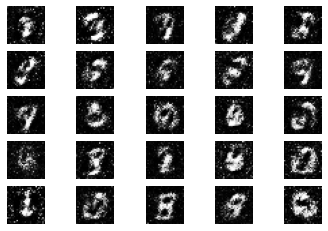

1001 [D loss: 0.659088, acc.: 61.72%] [G loss: 0.770702]
1002 [D loss: 0.656668, acc.: 67.97%] [G loss: 0.760293]
1003 [D loss: 0.664329, acc.: 64.84%] [G loss: 0.769209]
1004 [D loss: 0.650569, acc.: 64.84%] [G loss: 0.770666]
1005 [D loss: 0.658827, acc.: 58.59%] [G loss: 0.768431]
1006 [D loss: 0.669698, acc.: 58.98%] [G loss: 0.775076]
1007 [D loss: 0.672348, acc.: 59.77%] [G loss: 0.778329]
1008 [D loss: 0.677151, acc.: 57.03%] [G loss: 0.767567]
1009 [D loss: 0.653644, acc.: 62.89%] [G loss: 0.768457]
1010 [D loss: 0.656686, acc.: 60.16%] [G loss: 0.765254]
1011 [D loss: 0.655357, acc.: 63.67%] [G loss: 0.770083]
1012 [D loss: 0.650328, acc.: 66.41%] [G loss: 0.777869]
1013 [D loss: 0.653793, acc.: 61.72%] [G loss: 0.771354]
1014 [D loss: 0.649111, acc.: 63.28%] [G loss: 0.785227]
1015 [D loss: 0.669221, acc.: 57.81%] [G loss: 0.772543]
1016 [D loss: 0.654892, acc.: 66.02%] [G loss: 0.797314]
1017 [D loss: 0.669401, acc.: 58.20%] [G loss: 0.766684]
1018 [D loss: 0.657844, acc.: 5

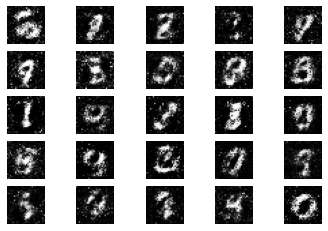

1201 [D loss: 0.643756, acc.: 66.41%] [G loss: 0.789038]
1202 [D loss: 0.660429, acc.: 58.98%] [G loss: 0.778838]
1203 [D loss: 0.646883, acc.: 66.41%] [G loss: 0.789349]
1204 [D loss: 0.668267, acc.: 62.11%] [G loss: 0.779456]
1205 [D loss: 0.659384, acc.: 63.28%] [G loss: 0.760185]
1206 [D loss: 0.633631, acc.: 68.75%] [G loss: 0.792010]
1207 [D loss: 0.653039, acc.: 61.33%] [G loss: 0.764160]
1208 [D loss: 0.645613, acc.: 63.67%] [G loss: 0.787047]
1209 [D loss: 0.663549, acc.: 65.23%] [G loss: 0.780619]
1210 [D loss: 0.665750, acc.: 61.33%] [G loss: 0.770472]
1211 [D loss: 0.666375, acc.: 59.38%] [G loss: 0.764042]
1212 [D loss: 0.666451, acc.: 60.16%] [G loss: 0.773220]
1213 [D loss: 0.645965, acc.: 65.23%] [G loss: 0.786021]
1214 [D loss: 0.664296, acc.: 57.03%] [G loss: 0.778074]
1215 [D loss: 0.651856, acc.: 62.50%] [G loss: 0.782630]
1216 [D loss: 0.647390, acc.: 67.19%] [G loss: 0.775206]
1217 [D loss: 0.652987, acc.: 64.06%] [G loss: 0.774835]
1218 [D loss: 0.637881, acc.: 6

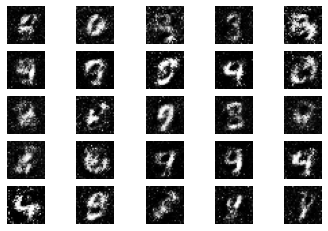

1401 [D loss: 0.664926, acc.: 58.20%] [G loss: 0.774944]
1402 [D loss: 0.660387, acc.: 61.33%] [G loss: 0.780320]
1403 [D loss: 0.654002, acc.: 64.84%] [G loss: 0.785305]
1404 [D loss: 0.642324, acc.: 66.41%] [G loss: 0.781302]
1405 [D loss: 0.654807, acc.: 59.77%] [G loss: 0.761457]
1406 [D loss: 0.653324, acc.: 65.23%] [G loss: 0.783329]
1407 [D loss: 0.641870, acc.: 67.97%] [G loss: 0.785069]
1408 [D loss: 0.651715, acc.: 64.45%] [G loss: 0.768436]
1409 [D loss: 0.650061, acc.: 63.28%] [G loss: 0.777753]
1410 [D loss: 0.647492, acc.: 66.02%] [G loss: 0.782891]
1411 [D loss: 0.645664, acc.: 63.67%] [G loss: 0.775341]
1412 [D loss: 0.641053, acc.: 64.84%] [G loss: 0.776031]
1413 [D loss: 0.642306, acc.: 66.41%] [G loss: 0.794276]
1414 [D loss: 0.640849, acc.: 64.45%] [G loss: 0.766418]
1415 [D loss: 0.661104, acc.: 62.89%] [G loss: 0.785682]
1416 [D loss: 0.664661, acc.: 61.33%] [G loss: 0.778879]
1417 [D loss: 0.655080, acc.: 63.28%] [G loss: 0.793218]
1418 [D loss: 0.654465, acc.: 6

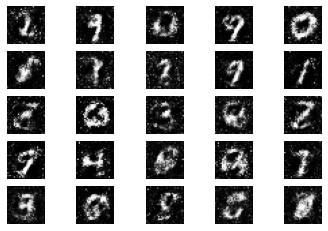

1601 [D loss: 0.662014, acc.: 62.11%] [G loss: 0.782996]
1602 [D loss: 0.636873, acc.: 68.36%] [G loss: 0.807123]
1603 [D loss: 0.651025, acc.: 61.72%] [G loss: 0.797198]
1604 [D loss: 0.646758, acc.: 64.45%] [G loss: 0.793110]
1605 [D loss: 0.648973, acc.: 62.89%] [G loss: 0.811062]
1606 [D loss: 0.652867, acc.: 64.06%] [G loss: 0.786045]
1607 [D loss: 0.633556, acc.: 65.62%] [G loss: 0.796781]
1608 [D loss: 0.622665, acc.: 69.14%] [G loss: 0.801559]
1609 [D loss: 0.637646, acc.: 64.84%] [G loss: 0.779949]
1610 [D loss: 0.634107, acc.: 68.36%] [G loss: 0.795969]
1611 [D loss: 0.651859, acc.: 64.06%] [G loss: 0.786689]
1612 [D loss: 0.652402, acc.: 64.06%] [G loss: 0.795457]
1613 [D loss: 0.633167, acc.: 70.70%] [G loss: 0.797760]
1614 [D loss: 0.639755, acc.: 67.97%] [G loss: 0.807547]
1615 [D loss: 0.652431, acc.: 59.77%] [G loss: 0.788366]
1616 [D loss: 0.635119, acc.: 67.58%] [G loss: 0.801384]
1617 [D loss: 0.643064, acc.: 67.97%] [G loss: 0.805347]
1618 [D loss: 0.664522, acc.: 6

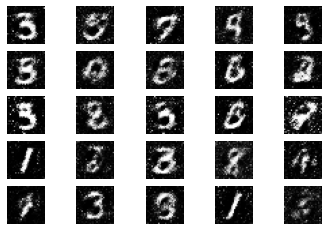

1801 [D loss: 0.643902, acc.: 66.02%] [G loss: 0.796136]
1802 [D loss: 0.630036, acc.: 67.58%] [G loss: 0.813688]
1803 [D loss: 0.644091, acc.: 66.02%] [G loss: 0.800744]
1804 [D loss: 0.641570, acc.: 66.02%] [G loss: 0.813084]
1805 [D loss: 0.631145, acc.: 68.36%] [G loss: 0.809043]
1806 [D loss: 0.656014, acc.: 62.11%] [G loss: 0.783926]
1807 [D loss: 0.633457, acc.: 67.97%] [G loss: 0.816643]
1808 [D loss: 0.621334, acc.: 70.70%] [G loss: 0.828461]
1809 [D loss: 0.642884, acc.: 63.67%] [G loss: 0.801655]
1810 [D loss: 0.630809, acc.: 67.19%] [G loss: 0.801960]
1811 [D loss: 0.641084, acc.: 68.75%] [G loss: 0.809025]
1812 [D loss: 0.629237, acc.: 69.53%] [G loss: 0.818099]
1813 [D loss: 0.639531, acc.: 64.06%] [G loss: 0.795652]
1814 [D loss: 0.620837, acc.: 66.02%] [G loss: 0.818298]
1815 [D loss: 0.637874, acc.: 64.45%] [G loss: 0.802674]
1816 [D loss: 0.644840, acc.: 63.67%] [G loss: 0.812163]
1817 [D loss: 0.642465, acc.: 64.84%] [G loss: 0.815321]
1818 [D loss: 0.630744, acc.: 6

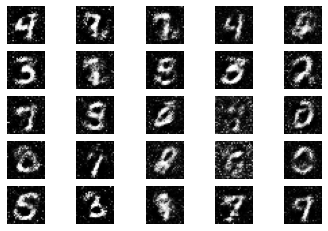

2001 [D loss: 0.636047, acc.: 67.58%] [G loss: 0.844046]
2002 [D loss: 0.631807, acc.: 69.14%] [G loss: 0.811356]
2003 [D loss: 0.614926, acc.: 70.70%] [G loss: 0.827969]
2004 [D loss: 0.636497, acc.: 64.84%] [G loss: 0.818421]
2005 [D loss: 0.635439, acc.: 66.41%] [G loss: 0.827349]
2006 [D loss: 0.609856, acc.: 72.27%] [G loss: 0.836944]
2007 [D loss: 0.658451, acc.: 62.50%] [G loss: 0.804509]
2008 [D loss: 0.649609, acc.: 64.06%] [G loss: 0.797689]
2009 [D loss: 0.642940, acc.: 66.80%] [G loss: 0.820393]
2010 [D loss: 0.636199, acc.: 65.23%] [G loss: 0.813840]
2011 [D loss: 0.641659, acc.: 66.02%] [G loss: 0.810622]
2012 [D loss: 0.602125, acc.: 70.70%] [G loss: 0.832869]
2013 [D loss: 0.639302, acc.: 66.80%] [G loss: 0.810719]
2014 [D loss: 0.632167, acc.: 70.31%] [G loss: 0.833820]
2015 [D loss: 0.638964, acc.: 67.19%] [G loss: 0.831087]
2016 [D loss: 0.639653, acc.: 66.41%] [G loss: 0.815434]
2017 [D loss: 0.630782, acc.: 67.97%] [G loss: 0.823699]
2018 [D loss: 0.633795, acc.: 6

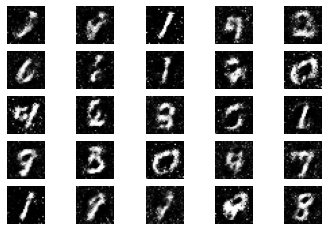

2201 [D loss: 0.603175, acc.: 72.27%] [G loss: 0.841138]
2202 [D loss: 0.630014, acc.: 65.62%] [G loss: 0.852120]
2203 [D loss: 0.624478, acc.: 68.36%] [G loss: 0.850558]
2204 [D loss: 0.624589, acc.: 65.23%] [G loss: 0.838153]
2205 [D loss: 0.620583, acc.: 71.48%] [G loss: 0.838725]
2206 [D loss: 0.611630, acc.: 70.70%] [G loss: 0.839851]
2207 [D loss: 0.635399, acc.: 70.31%] [G loss: 0.829329]
2208 [D loss: 0.633927, acc.: 64.06%] [G loss: 0.816115]
2209 [D loss: 0.616456, acc.: 70.31%] [G loss: 0.850749]
2210 [D loss: 0.618049, acc.: 71.09%] [G loss: 0.877392]
2211 [D loss: 0.613541, acc.: 70.31%] [G loss: 0.850305]
2212 [D loss: 0.611425, acc.: 72.66%] [G loss: 0.847889]
2213 [D loss: 0.637185, acc.: 64.84%] [G loss: 0.829146]
2214 [D loss: 0.606083, acc.: 72.66%] [G loss: 0.872763]
2215 [D loss: 0.624686, acc.: 71.09%] [G loss: 0.849969]
2216 [D loss: 0.614652, acc.: 75.00%] [G loss: 0.855207]
2217 [D loss: 0.617004, acc.: 68.75%] [G loss: 0.857709]
2218 [D loss: 0.629021, acc.: 6

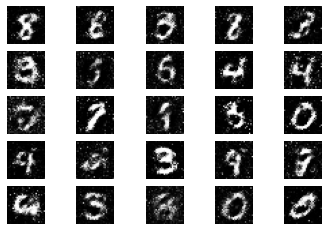

2401 [D loss: 0.622473, acc.: 67.97%] [G loss: 0.862257]
2402 [D loss: 0.614458, acc.: 70.70%] [G loss: 0.858539]
2403 [D loss: 0.608497, acc.: 71.48%] [G loss: 0.853399]
2404 [D loss: 0.616841, acc.: 69.53%] [G loss: 0.850114]
2405 [D loss: 0.641286, acc.: 66.02%] [G loss: 0.849335]
2406 [D loss: 0.632865, acc.: 67.97%] [G loss: 0.865603]
2407 [D loss: 0.636668, acc.: 65.23%] [G loss: 0.848386]
2408 [D loss: 0.608331, acc.: 71.09%] [G loss: 0.866096]
2409 [D loss: 0.650488, acc.: 62.89%] [G loss: 0.857580]
2410 [D loss: 0.625721, acc.: 68.75%] [G loss: 0.863265]
2411 [D loss: 0.608050, acc.: 75.78%] [G loss: 0.859106]
2412 [D loss: 0.624425, acc.: 69.14%] [G loss: 0.837401]
2413 [D loss: 0.604996, acc.: 71.09%] [G loss: 0.872258]
2414 [D loss: 0.610080, acc.: 67.97%] [G loss: 0.856824]
2415 [D loss: 0.621426, acc.: 69.14%] [G loss: 0.834420]
2416 [D loss: 0.637974, acc.: 62.89%] [G loss: 0.823163]
2417 [D loss: 0.635785, acc.: 65.62%] [G loss: 0.841016]
2418 [D loss: 0.628351, acc.: 6

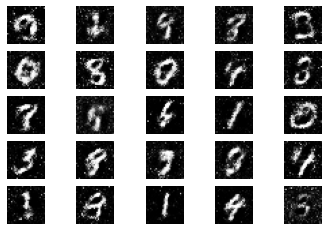

2601 [D loss: 0.620353, acc.: 68.36%] [G loss: 0.842306]
2602 [D loss: 0.597443, acc.: 73.44%] [G loss: 0.884076]
2603 [D loss: 0.630045, acc.: 66.80%] [G loss: 0.847566]
2604 [D loss: 0.643629, acc.: 63.28%] [G loss: 0.851077]
2605 [D loss: 0.628268, acc.: 66.41%] [G loss: 0.872421]
2606 [D loss: 0.617501, acc.: 71.88%] [G loss: 0.861837]
2607 [D loss: 0.616741, acc.: 70.70%] [G loss: 0.871617]
2608 [D loss: 0.613440, acc.: 69.14%] [G loss: 0.876840]
2609 [D loss: 0.613938, acc.: 68.36%] [G loss: 0.868772]
2610 [D loss: 0.628853, acc.: 68.36%] [G loss: 0.853768]
2611 [D loss: 0.615105, acc.: 71.09%] [G loss: 0.869321]
2612 [D loss: 0.622546, acc.: 67.97%] [G loss: 0.845112]
2613 [D loss: 0.615030, acc.: 69.92%] [G loss: 0.864531]
2614 [D loss: 0.626628, acc.: 67.97%] [G loss: 0.859597]
2615 [D loss: 0.602824, acc.: 71.48%] [G loss: 0.864609]
2616 [D loss: 0.603107, acc.: 73.44%] [G loss: 0.888951]
2617 [D loss: 0.609428, acc.: 75.00%] [G loss: 0.868754]
2618 [D loss: 0.614809, acc.: 7

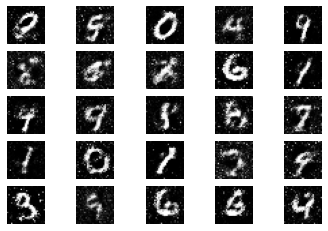

2801 [D loss: 0.656506, acc.: 62.50%] [G loss: 0.858855]
2802 [D loss: 0.639806, acc.: 66.80%] [G loss: 0.838307]
2803 [D loss: 0.602404, acc.: 72.66%] [G loss: 0.872921]
2804 [D loss: 0.621989, acc.: 69.53%] [G loss: 0.869019]
2805 [D loss: 0.612595, acc.: 69.14%] [G loss: 0.872540]
2806 [D loss: 0.620980, acc.: 69.14%] [G loss: 0.879057]
2807 [D loss: 0.647988, acc.: 60.94%] [G loss: 0.900904]
2808 [D loss: 0.621544, acc.: 67.97%] [G loss: 0.886681]
2809 [D loss: 0.643404, acc.: 64.06%] [G loss: 0.847301]
2810 [D loss: 0.602146, acc.: 73.83%] [G loss: 0.913815]
2811 [D loss: 0.631918, acc.: 69.14%] [G loss: 0.834106]
2812 [D loss: 0.637585, acc.: 67.19%] [G loss: 0.841095]
2813 [D loss: 0.627904, acc.: 64.84%] [G loss: 0.853343]
2814 [D loss: 0.598900, acc.: 67.97%] [G loss: 0.882517]
2815 [D loss: 0.636410, acc.: 62.89%] [G loss: 0.845633]
2816 [D loss: 0.613317, acc.: 69.14%] [G loss: 0.873997]
2817 [D loss: 0.622562, acc.: 68.75%] [G loss: 0.868379]
2818 [D loss: 0.612971, acc.: 6

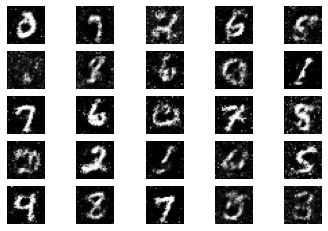

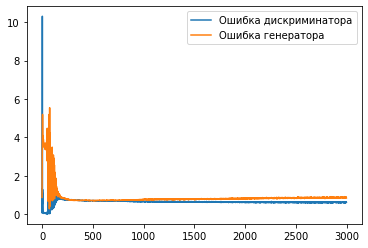

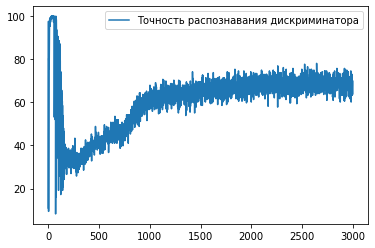

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 3000) # Вызываем функцию train с параметрами, generator, discriminator, 3000 (3000 - количество эпох)

# Размер внутреннего пространства генератора с 100 на 10
 Результат: 2999 [D loss: 0.695352, acc.: 51.17%] [G loss: 0.724032]
 
 Вывод: Визуально результат лучше при меньшем значении внутреннего пространства , в данном случае и точность выше. 

In [ ]:
latent_dim = 10 # Размерность скрытого пространства

0 [D loss: 0.929418, acc.: 10.16%] [G loss: 0.371718]


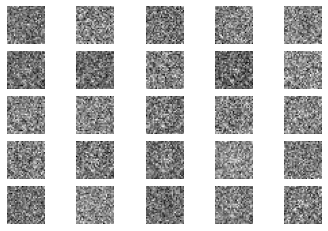

1 [D loss: 1.307096, acc.: 60.94%] [G loss: 4.596725]
2 [D loss: 0.277786, acc.: 84.77%] [G loss: 3.516647]
3 [D loss: 0.494740, acc.: 67.58%] [G loss: 2.275561]
4 [D loss: 6.715912, acc.: 3.91%] [G loss: 2.020967]
5 [D loss: 3.599092, acc.: 63.28%] [G loss: 6.582299]
6 [D loss: 1.571788, acc.: 71.48%] [G loss: 3.649917]
7 [D loss: 1.883077, acc.: 70.31%] [G loss: 4.239695]
8 [D loss: 2.223418, acc.: 57.03%] [G loss: 3.474380]
9 [D loss: 1.501080, acc.: 70.31%] [G loss: 4.975145]
10 [D loss: 0.411761, acc.: 82.42%] [G loss: 5.428743]
11 [D loss: 0.210413, acc.: 89.45%] [G loss: 4.862493]
12 [D loss: 1.487452, acc.: 53.12%] [G loss: 3.450476]
13 [D loss: 1.098920, acc.: 62.89%] [G loss: 4.565868]
14 [D loss: 0.263733, acc.: 87.89%] [G loss: 5.533700]
15 [D loss: 0.269010, acc.: 89.06%] [G loss: 5.041638]
16 [D loss: 0.463154, acc.: 79.30%] [G loss: 4.491647]
17 [D loss: 0.166112, acc.: 92.97%] [G loss: 4.950737]
18 [D loss: 0.532064, acc.: 80.86%] [G loss: 3.980092]
19 [D loss: 0.233475

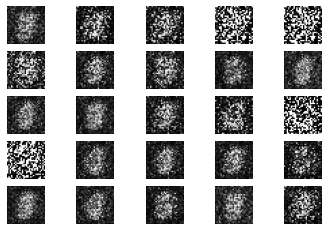

201 [D loss: 0.661057, acc.: 61.33%] [G loss: 1.593529]
202 [D loss: 0.623596, acc.: 66.41%] [G loss: 1.618713]
203 [D loss: 0.597143, acc.: 68.75%] [G loss: 1.626520]
204 [D loss: 0.650259, acc.: 58.98%] [G loss: 1.514973]
205 [D loss: 0.623576, acc.: 64.06%] [G loss: 1.580970]
206 [D loss: 0.666253, acc.: 58.98%] [G loss: 1.438829]
207 [D loss: 0.655843, acc.: 61.33%] [G loss: 1.457586]
208 [D loss: 0.668447, acc.: 60.16%] [G loss: 1.404667]
209 [D loss: 0.666842, acc.: 60.55%] [G loss: 1.472890]
210 [D loss: 0.669988, acc.: 61.72%] [G loss: 1.473073]
211 [D loss: 0.689992, acc.: 61.72%] [G loss: 1.420579]
212 [D loss: 0.655194, acc.: 64.45%] [G loss: 1.273914]
213 [D loss: 0.642095, acc.: 64.45%] [G loss: 1.411226]
214 [D loss: 0.628103, acc.: 64.45%] [G loss: 1.443872]
215 [D loss: 0.675830, acc.: 58.98%] [G loss: 1.430970]
216 [D loss: 0.623095, acc.: 65.62%] [G loss: 1.495661]
217 [D loss: 0.724445, acc.: 53.52%] [G loss: 1.671595]
218 [D loss: 0.651562, acc.: 61.33%] [G loss: 1.

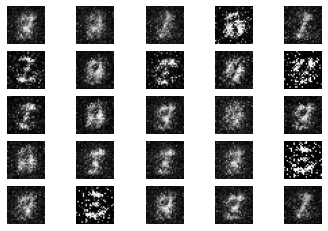

401 [D loss: 0.705724, acc.: 42.97%] [G loss: 0.769036]
402 [D loss: 0.703450, acc.: 41.02%] [G loss: 0.782987]
403 [D loss: 0.708190, acc.: 44.14%] [G loss: 0.762986]
404 [D loss: 0.704490, acc.: 44.14%] [G loss: 0.757402]
405 [D loss: 0.692267, acc.: 48.44%] [G loss: 0.785683]
406 [D loss: 0.707232, acc.: 43.75%] [G loss: 0.766323]
407 [D loss: 0.704976, acc.: 42.97%] [G loss: 0.769300]
408 [D loss: 0.714219, acc.: 44.14%] [G loss: 0.767090]
409 [D loss: 0.701697, acc.: 47.27%] [G loss: 0.746537]
410 [D loss: 0.713936, acc.: 44.14%] [G loss: 0.757534]
411 [D loss: 0.713236, acc.: 43.75%] [G loss: 0.773653]
412 [D loss: 0.719149, acc.: 43.36%] [G loss: 0.764113]
413 [D loss: 0.705629, acc.: 42.58%] [G loss: 0.751933]
414 [D loss: 0.714090, acc.: 45.31%] [G loss: 0.769027]
415 [D loss: 0.694775, acc.: 44.53%] [G loss: 0.774945]
416 [D loss: 0.701648, acc.: 42.58%] [G loss: 0.763768]
417 [D loss: 0.700867, acc.: 45.31%] [G loss: 0.766095]
418 [D loss: 0.697128, acc.: 46.09%] [G loss: 0.

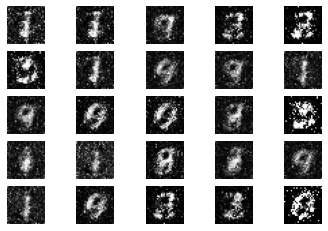

601 [D loss: 0.696255, acc.: 48.05%] [G loss: 0.757416]
602 [D loss: 0.690549, acc.: 45.70%] [G loss: 0.759849]
603 [D loss: 0.690601, acc.: 42.58%] [G loss: 0.765584]
604 [D loss: 0.684691, acc.: 46.48%] [G loss: 0.758115]
605 [D loss: 0.688685, acc.: 46.09%] [G loss: 0.755711]
606 [D loss: 0.698563, acc.: 46.09%] [G loss: 0.752560]
607 [D loss: 0.686202, acc.: 45.31%] [G loss: 0.752561]
608 [D loss: 0.669140, acc.: 53.12%] [G loss: 0.747750]
609 [D loss: 0.699990, acc.: 47.66%] [G loss: 0.757945]
610 [D loss: 0.684523, acc.: 51.17%] [G loss: 0.766353]
611 [D loss: 0.679824, acc.: 54.30%] [G loss: 0.764610]
612 [D loss: 0.672086, acc.: 55.86%] [G loss: 0.767226]
613 [D loss: 0.674964, acc.: 54.69%] [G loss: 0.763404]
614 [D loss: 0.673528, acc.: 57.81%] [G loss: 0.762638]
615 [D loss: 0.666040, acc.: 57.81%] [G loss: 0.781398]
616 [D loss: 0.681628, acc.: 46.48%] [G loss: 0.772688]
617 [D loss: 0.681161, acc.: 52.73%] [G loss: 0.776835]
618 [D loss: 0.665473, acc.: 54.30%] [G loss: 0.

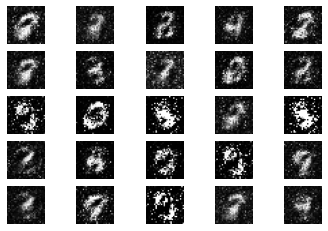

801 [D loss: 0.701625, acc.: 42.97%] [G loss: 0.738092]
802 [D loss: 0.692019, acc.: 48.05%] [G loss: 0.744348]
803 [D loss: 0.688852, acc.: 48.05%] [G loss: 0.760831]
804 [D loss: 0.695081, acc.: 44.92%] [G loss: 0.751415]
805 [D loss: 0.694056, acc.: 43.36%] [G loss: 0.751410]
806 [D loss: 0.687466, acc.: 48.05%] [G loss: 0.759870]
807 [D loss: 0.683355, acc.: 46.48%] [G loss: 0.753248]
808 [D loss: 0.699215, acc.: 41.41%] [G loss: 0.751511]
809 [D loss: 0.675026, acc.: 49.22%] [G loss: 0.760187]
810 [D loss: 0.687037, acc.: 51.17%] [G loss: 0.759739]
811 [D loss: 0.667565, acc.: 52.73%] [G loss: 0.778905]
812 [D loss: 0.679212, acc.: 54.69%] [G loss: 0.778568]
813 [D loss: 0.677821, acc.: 54.30%] [G loss: 0.781489]
814 [D loss: 0.684063, acc.: 50.39%] [G loss: 0.773245]
815 [D loss: 0.670521, acc.: 54.30%] [G loss: 0.776458]
816 [D loss: 0.677644, acc.: 53.52%] [G loss: 0.777170]
817 [D loss: 0.677618, acc.: 52.34%] [G loss: 0.765992]
818 [D loss: 0.675925, acc.: 55.08%] [G loss: 0.

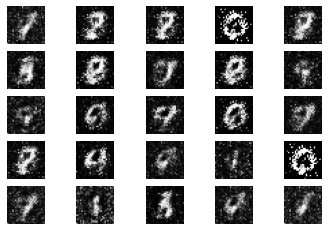

1001 [D loss: 0.708892, acc.: 46.09%] [G loss: 0.780716]
1002 [D loss: 0.669495, acc.: 58.20%] [G loss: 0.793748]
1003 [D loss: 0.675906, acc.: 51.95%] [G loss: 0.788680]
1004 [D loss: 0.678325, acc.: 57.42%] [G loss: 0.783585]
1005 [D loss: 0.678134, acc.: 55.08%] [G loss: 0.771620]
1006 [D loss: 0.684128, acc.: 52.34%] [G loss: 0.773700]
1007 [D loss: 0.688080, acc.: 54.69%] [G loss: 0.778510]
1008 [D loss: 0.682602, acc.: 58.20%] [G loss: 0.781956]
1009 [D loss: 0.673024, acc.: 58.20%] [G loss: 0.771885]
1010 [D loss: 0.674350, acc.: 56.25%] [G loss: 0.754450]
1011 [D loss: 0.676524, acc.: 55.47%] [G loss: 0.776100]
1012 [D loss: 0.661095, acc.: 60.94%] [G loss: 0.789969]
1013 [D loss: 0.667714, acc.: 58.98%] [G loss: 0.787642]
1014 [D loss: 0.681357, acc.: 54.69%] [G loss: 0.774508]
1015 [D loss: 0.662024, acc.: 57.03%] [G loss: 0.793441]
1016 [D loss: 0.670487, acc.: 58.59%] [G loss: 0.778846]
1017 [D loss: 0.667496, acc.: 56.25%] [G loss: 0.784104]
1018 [D loss: 0.686308, acc.: 5

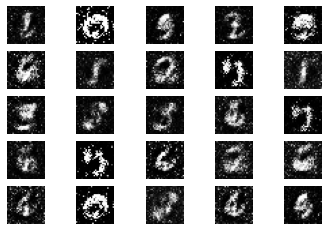

1201 [D loss: 0.649216, acc.: 66.80%] [G loss: 0.770810]
1202 [D loss: 0.670054, acc.: 59.38%] [G loss: 0.772955]
1203 [D loss: 0.682448, acc.: 51.95%] [G loss: 0.768288]
1204 [D loss: 0.664176, acc.: 56.25%] [G loss: 0.767429]
1205 [D loss: 0.664356, acc.: 58.98%] [G loss: 0.769192]
1206 [D loss: 0.672379, acc.: 53.91%] [G loss: 0.769837]
1207 [D loss: 0.660322, acc.: 59.38%] [G loss: 0.771704]
1208 [D loss: 0.659773, acc.: 62.50%] [G loss: 0.775493]
1209 [D loss: 0.656173, acc.: 64.84%] [G loss: 0.777383]
1210 [D loss: 0.668928, acc.: 56.25%] [G loss: 0.757773]
1211 [D loss: 0.664690, acc.: 54.69%] [G loss: 0.745414]
1212 [D loss: 0.666240, acc.: 53.91%] [G loss: 0.755544]
1213 [D loss: 0.655054, acc.: 55.86%] [G loss: 0.768283]
1214 [D loss: 0.654237, acc.: 62.50%] [G loss: 0.769909]
1215 [D loss: 0.662559, acc.: 58.20%] [G loss: 0.768845]
1216 [D loss: 0.677593, acc.: 52.73%] [G loss: 0.764218]
1217 [D loss: 0.677655, acc.: 51.56%] [G loss: 0.765194]
1218 [D loss: 0.667954, acc.: 5

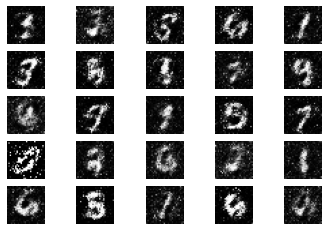

1401 [D loss: 0.684139, acc.: 49.61%] [G loss: 0.749156]
1402 [D loss: 0.672036, acc.: 56.64%] [G loss: 0.758773]
1403 [D loss: 0.672918, acc.: 57.81%] [G loss: 0.738669]
1404 [D loss: 0.657314, acc.: 62.11%] [G loss: 0.754525]
1405 [D loss: 0.675098, acc.: 55.47%] [G loss: 0.750367]
1406 [D loss: 0.675082, acc.: 57.03%] [G loss: 0.740804]
1407 [D loss: 0.685843, acc.: 51.95%] [G loss: 0.747802]
1408 [D loss: 0.671896, acc.: 58.59%] [G loss: 0.762759]
1409 [D loss: 0.674331, acc.: 53.91%] [G loss: 0.751485]
1410 [D loss: 0.682705, acc.: 53.12%] [G loss: 0.756057]
1411 [D loss: 0.680782, acc.: 54.30%] [G loss: 0.759730]
1412 [D loss: 0.686044, acc.: 51.17%] [G loss: 0.750347]
1413 [D loss: 0.668492, acc.: 58.59%] [G loss: 0.770659]
1414 [D loss: 0.680351, acc.: 56.64%] [G loss: 0.758533]
1415 [D loss: 0.678430, acc.: 55.86%] [G loss: 0.753121]
1416 [D loss: 0.673196, acc.: 55.08%] [G loss: 0.755068]
1417 [D loss: 0.676725, acc.: 57.42%] [G loss: 0.761248]
1418 [D loss: 0.677392, acc.: 5

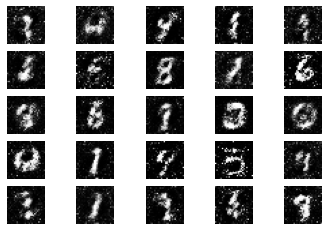

1601 [D loss: 0.698470, acc.: 48.05%] [G loss: 0.723906]
1602 [D loss: 0.696527, acc.: 48.05%] [G loss: 0.734720]
1603 [D loss: 0.680149, acc.: 57.42%] [G loss: 0.739630]
1604 [D loss: 0.702334, acc.: 48.83%] [G loss: 0.734074]
1605 [D loss: 0.703530, acc.: 44.14%] [G loss: 0.728402]
1606 [D loss: 0.700730, acc.: 51.17%] [G loss: 0.744291]
1607 [D loss: 0.693558, acc.: 48.05%] [G loss: 0.731923]
1608 [D loss: 0.683965, acc.: 54.69%] [G loss: 0.746902]
1609 [D loss: 0.691961, acc.: 50.00%] [G loss: 0.730617]
1610 [D loss: 0.678332, acc.: 57.03%] [G loss: 0.739211]
1611 [D loss: 0.690695, acc.: 50.00%] [G loss: 0.737905]
1612 [D loss: 0.684895, acc.: 51.56%] [G loss: 0.732561]
1613 [D loss: 0.684803, acc.: 52.73%] [G loss: 0.720244]
1614 [D loss: 0.686850, acc.: 54.30%] [G loss: 0.726039]
1615 [D loss: 0.688223, acc.: 54.30%] [G loss: 0.735159]
1616 [D loss: 0.683175, acc.: 51.95%] [G loss: 0.740559]
1617 [D loss: 0.683172, acc.: 53.52%] [G loss: 0.748732]
1618 [D loss: 0.689354, acc.: 4

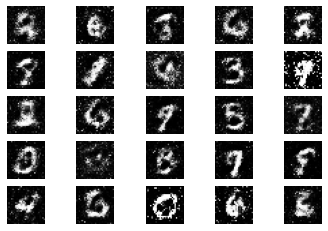

1801 [D loss: 0.690724, acc.: 51.17%] [G loss: 0.744858]
1802 [D loss: 0.678530, acc.: 52.34%] [G loss: 0.749274]
1803 [D loss: 0.682684, acc.: 51.95%] [G loss: 0.740245]
1804 [D loss: 0.691182, acc.: 50.00%] [G loss: 0.739983]
1805 [D loss: 0.681912, acc.: 51.56%] [G loss: 0.740387]
1806 [D loss: 0.692539, acc.: 48.83%] [G loss: 0.735708]
1807 [D loss: 0.691267, acc.: 44.53%] [G loss: 0.733516]
1808 [D loss: 0.690797, acc.: 49.61%] [G loss: 0.733902]
1809 [D loss: 0.692318, acc.: 52.34%] [G loss: 0.727486]
1810 [D loss: 0.678952, acc.: 52.34%] [G loss: 0.738114]
1811 [D loss: 0.694538, acc.: 46.09%] [G loss: 0.722522]
1812 [D loss: 0.690064, acc.: 52.34%] [G loss: 0.723501]
1813 [D loss: 0.686397, acc.: 51.95%] [G loss: 0.721990]
1814 [D loss: 0.696219, acc.: 49.22%] [G loss: 0.715451]
1815 [D loss: 0.687787, acc.: 48.05%] [G loss: 0.730230]
1816 [D loss: 0.693675, acc.: 52.73%] [G loss: 0.732057]
1817 [D loss: 0.677743, acc.: 54.69%] [G loss: 0.736214]
1818 [D loss: 0.690767, acc.: 5

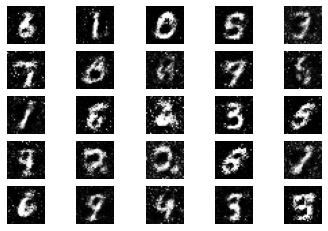

2001 [D loss: 0.690635, acc.: 49.22%] [G loss: 0.723002]
2002 [D loss: 0.683513, acc.: 54.69%] [G loss: 0.729075]
2003 [D loss: 0.690587, acc.: 50.78%] [G loss: 0.721638]
2004 [D loss: 0.692394, acc.: 50.78%] [G loss: 0.718949]
2005 [D loss: 0.698971, acc.: 46.09%] [G loss: 0.725035]
2006 [D loss: 0.678058, acc.: 57.03%] [G loss: 0.731240]
2007 [D loss: 0.693034, acc.: 50.00%] [G loss: 0.727676]
2008 [D loss: 0.692421, acc.: 48.05%] [G loss: 0.726107]
2009 [D loss: 0.683983, acc.: 54.30%] [G loss: 0.732487]
2010 [D loss: 0.693273, acc.: 48.44%] [G loss: 0.727419]
2011 [D loss: 0.685242, acc.: 56.25%] [G loss: 0.739466]
2012 [D loss: 0.700311, acc.: 44.53%] [G loss: 0.728424]
2013 [D loss: 0.695290, acc.: 48.83%] [G loss: 0.724787]
2014 [D loss: 0.693350, acc.: 51.17%] [G loss: 0.721818]
2015 [D loss: 0.696748, acc.: 44.53%] [G loss: 0.717288]
2016 [D loss: 0.693600, acc.: 50.00%] [G loss: 0.722856]
2017 [D loss: 0.691436, acc.: 49.61%] [G loss: 0.726710]
2018 [D loss: 0.700981, acc.: 5

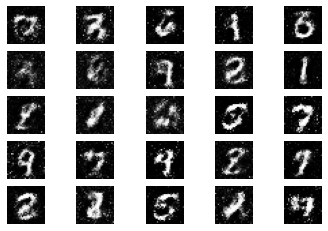

2201 [D loss: 0.693444, acc.: 49.61%] [G loss: 0.739741]
2202 [D loss: 0.683369, acc.: 51.95%] [G loss: 0.735272]
2203 [D loss: 0.687035, acc.: 54.69%] [G loss: 0.738071]
2204 [D loss: 0.693926, acc.: 47.66%] [G loss: 0.730413]
2205 [D loss: 0.685280, acc.: 54.30%] [G loss: 0.726038]
2206 [D loss: 0.690691, acc.: 52.34%] [G loss: 0.724428]
2207 [D loss: 0.688136, acc.: 54.69%] [G loss: 0.731878]
2208 [D loss: 0.687496, acc.: 50.78%] [G loss: 0.736752]
2209 [D loss: 0.692159, acc.: 53.52%] [G loss: 0.721604]
2210 [D loss: 0.682981, acc.: 57.42%] [G loss: 0.725574]
2211 [D loss: 0.686189, acc.: 53.12%] [G loss: 0.723858]
2212 [D loss: 0.688270, acc.: 51.95%] [G loss: 0.724418]
2213 [D loss: 0.685859, acc.: 53.52%] [G loss: 0.720209]
2214 [D loss: 0.688099, acc.: 56.25%] [G loss: 0.722248]
2215 [D loss: 0.683796, acc.: 57.81%] [G loss: 0.733295]
2216 [D loss: 0.684249, acc.: 55.86%] [G loss: 0.726454]
2217 [D loss: 0.689804, acc.: 53.12%] [G loss: 0.731260]
2218 [D loss: 0.680337, acc.: 5

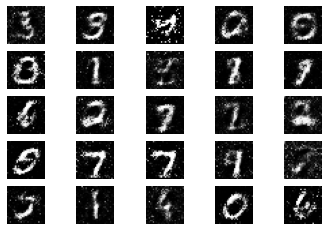

2401 [D loss: 0.693243, acc.: 51.17%] [G loss: 0.742276]
2402 [D loss: 0.683364, acc.: 57.81%] [G loss: 0.743452]
2403 [D loss: 0.683285, acc.: 60.55%] [G loss: 0.725074]
2404 [D loss: 0.685218, acc.: 55.86%] [G loss: 0.729630]
2405 [D loss: 0.688441, acc.: 53.52%] [G loss: 0.734369]
2406 [D loss: 0.688565, acc.: 57.42%] [G loss: 0.720845]
2407 [D loss: 0.684819, acc.: 57.42%] [G loss: 0.732734]
2408 [D loss: 0.697544, acc.: 48.05%] [G loss: 0.716563]
2409 [D loss: 0.689846, acc.: 49.22%] [G loss: 0.721120]
2410 [D loss: 0.685662, acc.: 53.12%] [G loss: 0.723186]
2411 [D loss: 0.689048, acc.: 49.22%] [G loss: 0.720203]
2412 [D loss: 0.693169, acc.: 49.22%] [G loss: 0.723036]
2413 [D loss: 0.679552, acc.: 59.77%] [G loss: 0.733023]
2414 [D loss: 0.678543, acc.: 57.42%] [G loss: 0.723036]
2415 [D loss: 0.689123, acc.: 51.56%] [G loss: 0.730823]
2416 [D loss: 0.688819, acc.: 51.95%] [G loss: 0.735109]
2417 [D loss: 0.694388, acc.: 51.17%] [G loss: 0.729647]
2418 [D loss: 0.694844, acc.: 5

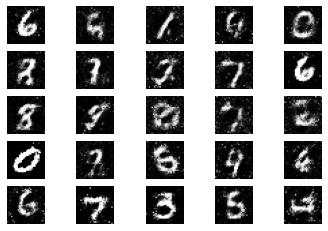

2601 [D loss: 0.684883, acc.: 54.30%] [G loss: 0.738158]
2602 [D loss: 0.685862, acc.: 51.56%] [G loss: 0.737431]
2603 [D loss: 0.687072, acc.: 58.98%] [G loss: 0.738196]
2604 [D loss: 0.694327, acc.: 52.73%] [G loss: 0.723029]
2605 [D loss: 0.697701, acc.: 46.09%] [G loss: 0.721353]
2606 [D loss: 0.683790, acc.: 55.47%] [G loss: 0.725143]
2607 [D loss: 0.689854, acc.: 53.52%] [G loss: 0.724025]
2608 [D loss: 0.687200, acc.: 55.47%] [G loss: 0.728705]
2609 [D loss: 0.698922, acc.: 48.83%] [G loss: 0.727611]
2610 [D loss: 0.690260, acc.: 52.34%] [G loss: 0.728151]
2611 [D loss: 0.690856, acc.: 50.78%] [G loss: 0.726414]
2612 [D loss: 0.688543, acc.: 47.66%] [G loss: 0.731740]
2613 [D loss: 0.690671, acc.: 51.17%] [G loss: 0.726595]
2614 [D loss: 0.681671, acc.: 55.08%] [G loss: 0.729826]
2615 [D loss: 0.686521, acc.: 53.91%] [G loss: 0.733947]
2616 [D loss: 0.695123, acc.: 48.44%] [G loss: 0.722834]
2617 [D loss: 0.691371, acc.: 52.73%] [G loss: 0.736721]
2618 [D loss: 0.679023, acc.: 5

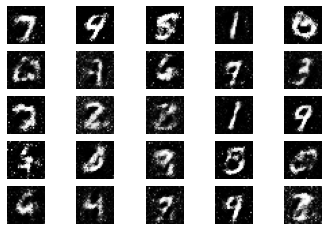

2801 [D loss: 0.687721, acc.: 54.30%] [G loss: 0.737059]
2802 [D loss: 0.693886, acc.: 50.39%] [G loss: 0.724929]
2803 [D loss: 0.690713, acc.: 51.56%] [G loss: 0.722468]
2804 [D loss: 0.691971, acc.: 48.05%] [G loss: 0.725451]
2805 [D loss: 0.684751, acc.: 57.81%] [G loss: 0.721079]
2806 [D loss: 0.686105, acc.: 56.64%] [G loss: 0.731246]
2807 [D loss: 0.687289, acc.: 52.34%] [G loss: 0.725154]
2808 [D loss: 0.675610, acc.: 61.33%] [G loss: 0.740130]
2809 [D loss: 0.683188, acc.: 57.81%] [G loss: 0.739768]
2810 [D loss: 0.693344, acc.: 52.34%] [G loss: 0.732506]
2811 [D loss: 0.685199, acc.: 53.91%] [G loss: 0.754796]
2812 [D loss: 0.690200, acc.: 50.00%] [G loss: 0.738179]
2813 [D loss: 0.694848, acc.: 49.22%] [G loss: 0.738584]
2814 [D loss: 0.685754, acc.: 60.94%] [G loss: 0.737616]
2815 [D loss: 0.681521, acc.: 60.55%] [G loss: 0.725147]
2816 [D loss: 0.687758, acc.: 54.69%] [G loss: 0.724655]
2817 [D loss: 0.683587, acc.: 56.25%] [G loss: 0.721382]
2818 [D loss: 0.680851, acc.: 5

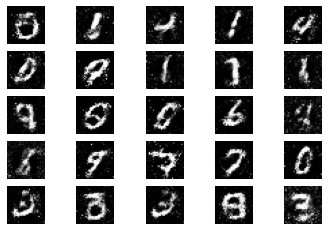

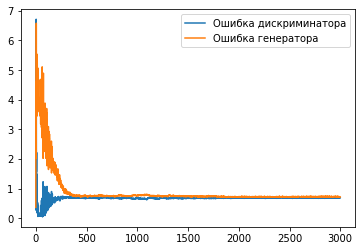

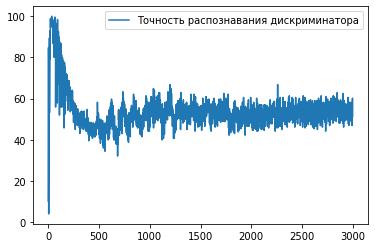

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 3000) # Вызываем функцию train с параметрами, generator, discriminator, 3000 (3000 - количество эпох)

# Свёрточный генератор
Результат: 2999 [D loss: 0.647046, acc.: 66.41%] [G loss: 0.834932]

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [ ]:
def create_conv_generator(): # Функция создания генератора
  generator_conv = Sequential() # Инициализируем модель generator 
   
  generator_conv.add(Dense(np.prod(img_shape), input_dim = latent_dim))   
  generator_conv.add(Reshape(img_shape))                    
  generator_conv.add(Conv2D(16,(2,2), padding='same'))

  generator_conv.add(BatchNormalization())   
  generator_conv.add(LeakyReLU(alpha=0.01))   
  generator_conv.add(Conv2D(16,(2,2), padding='same'))
  generator_conv.add(BatchNormalization())   
  generator_conv.add(LeakyReLU(alpha=0.01))   
  generator_conv.add(Conv2D(4,(2,2), padding='same'))
  generator_conv.add(Activation('tanh')) 
  generator_conv.add(BatchNormalization())
  generator_conv.add(Flatten())
  generator_conv.add(Dense(np.prod(img_shape), activation='tanh'))
  generator_conv.add(Reshape(img_shape)) 
      
  noise = Input(shape=(latent_dim,))
  img = generator_conv(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

  generator_conv = Model(noise, img) # создаем модель generator (входные данные: noise, выходные данные: img)

  return generator_conv # Функция возвращаем generator

In [ ]:
gen_conv = create_conv_generator()
gen_conv.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_38 (Sequential)  (None, 28, 28, 1)         2540116   
                                                                 
Total params: 2,540,116
Trainable params: 2,540,044
Non-trainable params: 72
_________________________________________________________________


0 [D loss: 0.625004, acc.: 50.39%] [G loss: 0.668357]


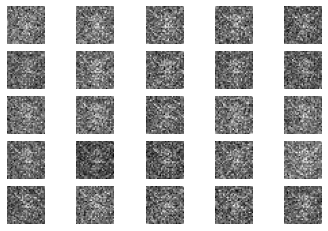

1 [D loss: 3.607643, acc.: 50.00%] [G loss: 0.271933]
2 [D loss: 2.895658, acc.: 47.66%] [G loss: 0.000157]
3 [D loss: 1.317018, acc.: 50.00%] [G loss: 0.609170]
4 [D loss: 0.263651, acc.: 95.31%] [G loss: 4.484475]
5 [D loss: 1.428278, acc.: 10.16%] [G loss: 0.001597]
6 [D loss: 0.481032, acc.: 67.58%] [G loss: 0.051651]
7 [D loss: 0.403341, acc.: 76.17%] [G loss: 0.037022]
8 [D loss: 0.608931, acc.: 67.97%] [G loss: 0.078656]
9 [D loss: 0.783600, acc.: 57.81%] [G loss: 0.061804]
10 [D loss: 0.806557, acc.: 55.86%] [G loss: 0.893263]
11 [D loss: 0.651644, acc.: 57.42%] [G loss: 5.358357]
12 [D loss: 0.295531, acc.: 85.94%] [G loss: 9.161707]
13 [D loss: 0.337464, acc.: 81.25%] [G loss: 8.124207]
14 [D loss: 3.928048, acc.: 1.17%] [G loss: 0.000001]
15 [D loss: 0.926246, acc.: 62.11%] [G loss: 0.000002]
16 [D loss: 0.454285, acc.: 78.52%] [G loss: 0.008400]
17 [D loss: 0.178460, acc.: 91.41%] [G loss: 0.036664]
18 [D loss: 0.066937, acc.: 96.48%] [G loss: 0.099105]
19 [D loss: 0.146519

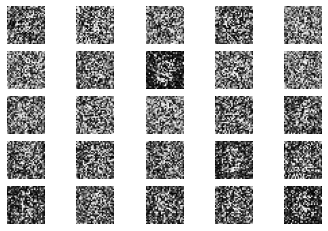

201 [D loss: 0.033515, acc.: 99.22%] [G loss: 0.015567]
202 [D loss: 0.033595, acc.: 99.22%] [G loss: 0.096609]
203 [D loss: 0.047986, acc.: 98.44%] [G loss: 0.046144]
204 [D loss: 0.033461, acc.: 99.22%] [G loss: 0.026344]
205 [D loss: 0.035757, acc.: 98.44%] [G loss: 0.087592]
206 [D loss: 0.066736, acc.: 97.66%] [G loss: 0.035389]
207 [D loss: 0.025753, acc.: 99.61%] [G loss: 0.039835]
208 [D loss: 0.054774, acc.: 97.66%] [G loss: 0.028472]
209 [D loss: 0.032174, acc.: 99.61%] [G loss: 0.040829]
210 [D loss: 0.043207, acc.: 97.66%] [G loss: 0.043496]
211 [D loss: 0.032187, acc.: 99.61%] [G loss: 0.030757]
212 [D loss: 0.126636, acc.: 94.92%] [G loss: 0.374398]
213 [D loss: 0.452794, acc.: 84.77%] [G loss: 0.013095]
214 [D loss: 0.128180, acc.: 94.53%] [G loss: 0.694859]
215 [D loss: 0.842005, acc.: 73.44%] [G loss: 0.057218]
216 [D loss: 0.129820, acc.: 94.92%] [G loss: 1.469179]
217 [D loss: 2.403383, acc.: 28.52%] [G loss: 0.000780]
218 [D loss: 0.996928, acc.: 67.97%] [G loss: 0.

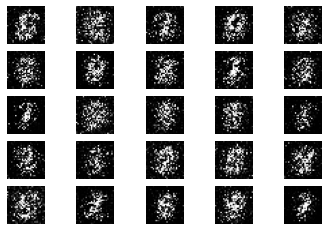

401 [D loss: 0.584390, acc.: 66.80%] [G loss: 1.490859]
402 [D loss: 0.579793, acc.: 68.75%] [G loss: 1.409359]
403 [D loss: 0.567383, acc.: 70.31%] [G loss: 1.236279]
404 [D loss: 0.475516, acc.: 80.86%] [G loss: 1.450302]
405 [D loss: 0.619664, acc.: 62.89%] [G loss: 1.241659]
406 [D loss: 0.513692, acc.: 77.73%] [G loss: 1.365900]
407 [D loss: 0.599780, acc.: 66.41%] [G loss: 1.149952]
408 [D loss: 0.590829, acc.: 67.19%] [G loss: 1.248374]
409 [D loss: 0.637064, acc.: 61.72%] [G loss: 1.207194]
410 [D loss: 0.645327, acc.: 60.55%] [G loss: 1.234436]
411 [D loss: 0.673863, acc.: 60.16%] [G loss: 1.156861]
412 [D loss: 0.572688, acc.: 69.53%] [G loss: 1.274649]
413 [D loss: 0.625747, acc.: 62.50%] [G loss: 1.121149]
414 [D loss: 0.584778, acc.: 67.97%] [G loss: 1.194185]
415 [D loss: 0.584584, acc.: 68.75%] [G loss: 1.206913]
416 [D loss: 0.631788, acc.: 63.28%] [G loss: 1.066541]
417 [D loss: 0.631647, acc.: 61.72%] [G loss: 1.200928]
418 [D loss: 0.600912, acc.: 66.02%] [G loss: 1.

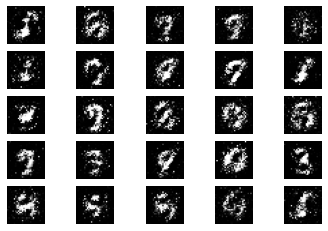

601 [D loss: 0.703085, acc.: 45.31%] [G loss: 0.866801]
602 [D loss: 0.718524, acc.: 41.41%] [G loss: 0.849222]
603 [D loss: 0.715663, acc.: 42.97%] [G loss: 0.835268]
604 [D loss: 0.718049, acc.: 44.92%] [G loss: 0.852993]
605 [D loss: 0.704669, acc.: 47.66%] [G loss: 0.865749]
606 [D loss: 0.707829, acc.: 42.19%] [G loss: 0.858884]
607 [D loss: 0.691627, acc.: 47.27%] [G loss: 0.886599]
608 [D loss: 0.707352, acc.: 44.92%] [G loss: 0.857836]
609 [D loss: 0.704583, acc.: 43.75%] [G loss: 0.874355]
610 [D loss: 0.704329, acc.: 42.58%] [G loss: 0.849691]
611 [D loss: 0.726571, acc.: 38.28%] [G loss: 0.850663]
612 [D loss: 0.685820, acc.: 50.78%] [G loss: 0.867961]
613 [D loss: 0.704807, acc.: 51.17%] [G loss: 0.873784]
614 [D loss: 0.715944, acc.: 42.97%] [G loss: 0.865482]
615 [D loss: 0.714376, acc.: 42.19%] [G loss: 0.859533]
616 [D loss: 0.707080, acc.: 42.19%] [G loss: 0.856275]
617 [D loss: 0.700822, acc.: 47.27%] [G loss: 0.881462]
618 [D loss: 0.699267, acc.: 48.83%] [G loss: 0.

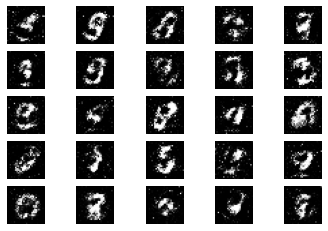

801 [D loss: 0.688580, acc.: 53.52%] [G loss: 0.816432]
802 [D loss: 0.695686, acc.: 47.66%] [G loss: 0.791017]
803 [D loss: 0.685876, acc.: 49.61%] [G loss: 0.821996]
804 [D loss: 0.690897, acc.: 52.73%] [G loss: 0.816483]
805 [D loss: 0.694855, acc.: 52.73%] [G loss: 0.820770]
806 [D loss: 0.704794, acc.: 43.36%] [G loss: 0.796562]
807 [D loss: 0.681306, acc.: 56.25%] [G loss: 0.817670]
808 [D loss: 0.687501, acc.: 53.12%] [G loss: 0.818319]
809 [D loss: 0.673993, acc.: 60.16%] [G loss: 0.841423]
810 [D loss: 0.689131, acc.: 51.95%] [G loss: 0.823786]
811 [D loss: 0.685254, acc.: 53.52%] [G loss: 0.816693]
812 [D loss: 0.695332, acc.: 50.00%] [G loss: 0.812087]
813 [D loss: 0.679764, acc.: 57.81%] [G loss: 0.835129]
814 [D loss: 0.692779, acc.: 51.56%] [G loss: 0.813284]
815 [D loss: 0.702394, acc.: 48.05%] [G loss: 0.812562]
816 [D loss: 0.699425, acc.: 50.00%] [G loss: 0.808526]
817 [D loss: 0.684547, acc.: 55.08%] [G loss: 0.835476]
818 [D loss: 0.683812, acc.: 54.69%] [G loss: 0.

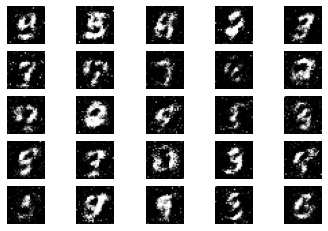

1001 [D loss: 0.648760, acc.: 62.50%] [G loss: 0.876194]
1002 [D loss: 0.643441, acc.: 62.11%] [G loss: 0.856513]
1003 [D loss: 0.666750, acc.: 59.77%] [G loss: 0.857183]
1004 [D loss: 0.640829, acc.: 60.16%] [G loss: 0.879179]
1005 [D loss: 0.654541, acc.: 58.59%] [G loss: 0.849520]
1006 [D loss: 0.622372, acc.: 71.09%] [G loss: 0.884051]
1007 [D loss: 0.642846, acc.: 63.28%] [G loss: 0.867813]
1008 [D loss: 0.625269, acc.: 67.19%] [G loss: 0.872235]
1009 [D loss: 0.642512, acc.: 60.94%] [G loss: 0.858846]
1010 [D loss: 0.646794, acc.: 62.11%] [G loss: 0.875222]
1011 [D loss: 0.639434, acc.: 66.02%] [G loss: 0.871023]
1012 [D loss: 0.652549, acc.: 61.72%] [G loss: 0.874217]
1013 [D loss: 0.646590, acc.: 61.72%] [G loss: 0.847290]
1014 [D loss: 0.640307, acc.: 62.89%] [G loss: 0.870175]
1015 [D loss: 0.615447, acc.: 70.31%] [G loss: 0.885039]
1016 [D loss: 0.639919, acc.: 64.06%] [G loss: 0.881723]
1017 [D loss: 0.637624, acc.: 62.89%] [G loss: 0.882164]
1018 [D loss: 0.637001, acc.: 6

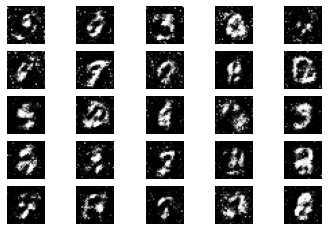

1201 [D loss: 0.584011, acc.: 73.83%] [G loss: 0.961524]
1202 [D loss: 0.590630, acc.: 67.19%] [G loss: 0.936580]
1203 [D loss: 0.602008, acc.: 66.41%] [G loss: 0.958460]
1204 [D loss: 0.588646, acc.: 71.88%] [G loss: 0.962178]
1205 [D loss: 0.588728, acc.: 68.75%] [G loss: 0.972142]
1206 [D loss: 0.582250, acc.: 74.22%] [G loss: 0.996040]
1207 [D loss: 0.615069, acc.: 66.02%] [G loss: 0.947202]
1208 [D loss: 0.607922, acc.: 67.58%] [G loss: 0.945257]
1209 [D loss: 0.581223, acc.: 72.66%] [G loss: 0.990531]
1210 [D loss: 0.597451, acc.: 67.19%] [G loss: 0.945496]
1211 [D loss: 0.589525, acc.: 66.80%] [G loss: 0.958570]
1212 [D loss: 0.603589, acc.: 68.36%] [G loss: 0.952580]
1213 [D loss: 0.611708, acc.: 66.41%] [G loss: 0.948914]
1214 [D loss: 0.601995, acc.: 66.02%] [G loss: 0.971094]
1215 [D loss: 0.604904, acc.: 69.53%] [G loss: 0.923710]
1216 [D loss: 0.606821, acc.: 64.84%] [G loss: 0.935916]
1217 [D loss: 0.603235, acc.: 69.92%] [G loss: 0.953941]
1218 [D loss: 0.605665, acc.: 6

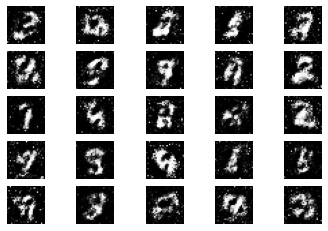

1401 [D loss: 0.556995, acc.: 74.22%] [G loss: 1.000919]
1402 [D loss: 0.567461, acc.: 72.27%] [G loss: 1.003443]
1403 [D loss: 0.573450, acc.: 70.31%] [G loss: 0.998758]
1404 [D loss: 0.551692, acc.: 74.22%] [G loss: 1.000992]
1405 [D loss: 0.608500, acc.: 66.80%] [G loss: 1.021916]
1406 [D loss: 0.562509, acc.: 71.09%] [G loss: 1.034786]
1407 [D loss: 0.564982, acc.: 73.44%] [G loss: 0.997024]
1408 [D loss: 0.563353, acc.: 74.22%] [G loss: 1.005584]
1409 [D loss: 0.572361, acc.: 68.36%] [G loss: 0.988129]
1410 [D loss: 0.545049, acc.: 75.78%] [G loss: 1.049529]
1411 [D loss: 0.550911, acc.: 72.27%] [G loss: 1.031669]
1412 [D loss: 0.581235, acc.: 69.53%] [G loss: 1.004147]
1413 [D loss: 0.603184, acc.: 68.36%] [G loss: 0.986754]
1414 [D loss: 0.580836, acc.: 71.09%] [G loss: 1.026291]
1415 [D loss: 0.605338, acc.: 64.06%] [G loss: 0.993725]
1416 [D loss: 0.616293, acc.: 63.28%] [G loss: 0.964430]
1417 [D loss: 0.572392, acc.: 73.05%] [G loss: 1.017685]
1418 [D loss: 0.558033, acc.: 7

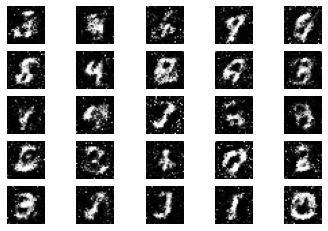

1601 [D loss: 0.587263, acc.: 71.09%] [G loss: 0.982030]
1602 [D loss: 0.621380, acc.: 65.62%] [G loss: 0.923541]
1603 [D loss: 0.632929, acc.: 67.97%] [G loss: 0.938530]
1604 [D loss: 0.617460, acc.: 71.48%] [G loss: 0.944884]
1605 [D loss: 0.610372, acc.: 68.75%] [G loss: 0.934121]
1606 [D loss: 0.625845, acc.: 67.19%] [G loss: 0.919619]
1607 [D loss: 0.625960, acc.: 65.23%] [G loss: 0.909419]
1608 [D loss: 0.600899, acc.: 64.84%] [G loss: 0.956723]
1609 [D loss: 0.594366, acc.: 71.09%] [G loss: 0.948602]
1610 [D loss: 0.605773, acc.: 69.53%] [G loss: 0.944967]
1611 [D loss: 0.600013, acc.: 71.09%] [G loss: 0.957835]
1612 [D loss: 0.609508, acc.: 69.14%] [G loss: 0.962433]
1613 [D loss: 0.638639, acc.: 64.84%] [G loss: 0.906579]
1614 [D loss: 0.610344, acc.: 67.19%] [G loss: 0.946616]
1615 [D loss: 0.648727, acc.: 60.55%] [G loss: 0.906118]
1616 [D loss: 0.639639, acc.: 63.28%] [G loss: 0.924367]
1617 [D loss: 0.612356, acc.: 67.97%] [G loss: 0.948269]
1618 [D loss: 0.610475, acc.: 6

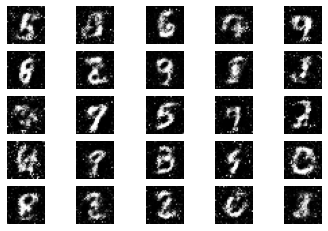

1801 [D loss: 0.606946, acc.: 69.14%] [G loss: 0.909627]
1802 [D loss: 0.634565, acc.: 61.33%] [G loss: 0.908453]
1803 [D loss: 0.631844, acc.: 64.84%] [G loss: 0.898064]
1804 [D loss: 0.623686, acc.: 67.97%] [G loss: 0.900667]
1805 [D loss: 0.605547, acc.: 69.14%] [G loss: 0.927850]
1806 [D loss: 0.630593, acc.: 66.02%] [G loss: 0.885877]
1807 [D loss: 0.647805, acc.: 63.28%] [G loss: 0.858488]
1808 [D loss: 0.626663, acc.: 64.45%] [G loss: 0.901024]
1809 [D loss: 0.620799, acc.: 64.84%] [G loss: 0.918371]
1810 [D loss: 0.658536, acc.: 59.77%] [G loss: 0.864783]
1811 [D loss: 0.596283, acc.: 69.14%] [G loss: 0.912207]
1812 [D loss: 0.636338, acc.: 62.50%] [G loss: 0.867129]
1813 [D loss: 0.628303, acc.: 67.58%] [G loss: 0.881655]
1814 [D loss: 0.626361, acc.: 64.84%] [G loss: 0.869709]
1815 [D loss: 0.633438, acc.: 67.58%] [G loss: 0.904098]
1816 [D loss: 0.625056, acc.: 65.23%] [G loss: 0.875712]
1817 [D loss: 0.619986, acc.: 65.23%] [G loss: 0.893606]
1818 [D loss: 0.632391, acc.: 6

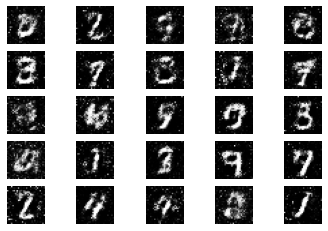

2001 [D loss: 0.629761, acc.: 66.02%] [G loss: 0.895379]
2002 [D loss: 0.635952, acc.: 64.84%] [G loss: 0.870805]
2003 [D loss: 0.611428, acc.: 69.92%] [G loss: 0.915754]
2004 [D loss: 0.633679, acc.: 68.75%] [G loss: 0.877782]
2005 [D loss: 0.641744, acc.: 65.62%] [G loss: 0.852259]
2006 [D loss: 0.652892, acc.: 64.45%] [G loss: 0.839032]
2007 [D loss: 0.639642, acc.: 64.45%] [G loss: 0.833158]
2008 [D loss: 0.643092, acc.: 61.72%] [G loss: 0.868203]
2009 [D loss: 0.650520, acc.: 61.72%] [G loss: 0.867421]
2010 [D loss: 0.650216, acc.: 61.33%] [G loss: 0.862932]
2011 [D loss: 0.607498, acc.: 63.67%] [G loss: 0.875315]
2012 [D loss: 0.661380, acc.: 61.33%] [G loss: 0.844146]
2013 [D loss: 0.640650, acc.: 67.19%] [G loss: 0.860139]
2014 [D loss: 0.619486, acc.: 67.97%] [G loss: 0.897453]
2015 [D loss: 0.620389, acc.: 66.41%] [G loss: 0.882397]
2016 [D loss: 0.644061, acc.: 60.55%] [G loss: 0.855791]
2017 [D loss: 0.642108, acc.: 62.50%] [G loss: 0.831112]
2018 [D loss: 0.651129, acc.: 6

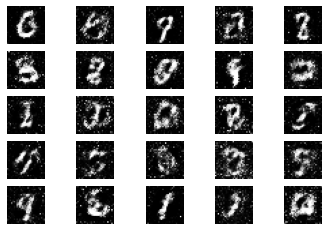

2201 [D loss: 0.671776, acc.: 56.64%] [G loss: 0.806845]
2202 [D loss: 0.653983, acc.: 62.50%] [G loss: 0.846763]
2203 [D loss: 0.626364, acc.: 66.41%] [G loss: 0.852328]
2204 [D loss: 0.653740, acc.: 62.89%] [G loss: 0.809460]
2205 [D loss: 0.665338, acc.: 60.94%] [G loss: 0.797055]
2206 [D loss: 0.639145, acc.: 62.11%] [G loss: 0.848985]
2207 [D loss: 0.632717, acc.: 65.62%] [G loss: 0.834997]
2208 [D loss: 0.642205, acc.: 65.62%] [G loss: 0.825199]
2209 [D loss: 0.626261, acc.: 68.36%] [G loss: 0.883739]
2210 [D loss: 0.639602, acc.: 65.62%] [G loss: 0.861513]
2211 [D loss: 0.667165, acc.: 60.55%] [G loss: 0.821894]
2212 [D loss: 0.637700, acc.: 66.02%] [G loss: 0.845426]
2213 [D loss: 0.656850, acc.: 62.50%] [G loss: 0.832634]
2214 [D loss: 0.673660, acc.: 57.03%] [G loss: 0.821076]
2215 [D loss: 0.648452, acc.: 62.11%] [G loss: 0.852067]
2216 [D loss: 0.648091, acc.: 61.72%] [G loss: 0.820114]
2217 [D loss: 0.654565, acc.: 57.42%] [G loss: 0.815864]
2218 [D loss: 0.649734, acc.: 6

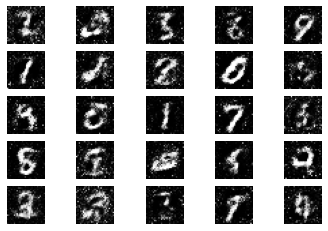

2401 [D loss: 0.666400, acc.: 57.81%] [G loss: 0.799382]
2402 [D loss: 0.631042, acc.: 65.62%] [G loss: 0.851154]
2403 [D loss: 0.631957, acc.: 65.23%] [G loss: 0.844999]
2404 [D loss: 0.659649, acc.: 64.06%] [G loss: 0.813686]
2405 [D loss: 0.654265, acc.: 57.81%] [G loss: 0.832235]
2406 [D loss: 0.632468, acc.: 64.06%] [G loss: 0.851251]
2407 [D loss: 0.678583, acc.: 55.08%] [G loss: 0.788139]
2408 [D loss: 0.614302, acc.: 69.14%] [G loss: 0.861365]
2409 [D loss: 0.665093, acc.: 58.98%] [G loss: 0.807652]
2410 [D loss: 0.661366, acc.: 59.38%] [G loss: 0.825285]
2411 [D loss: 0.641356, acc.: 62.50%] [G loss: 0.823366]
2412 [D loss: 0.641355, acc.: 63.28%] [G loss: 0.845025]
2413 [D loss: 0.623530, acc.: 68.75%] [G loss: 0.862734]
2414 [D loss: 0.652200, acc.: 62.89%] [G loss: 0.842949]
2415 [D loss: 0.657523, acc.: 59.38%] [G loss: 0.821496]
2416 [D loss: 0.644358, acc.: 62.11%] [G loss: 0.839647]
2417 [D loss: 0.656357, acc.: 61.72%] [G loss: 0.832967]
2418 [D loss: 0.652419, acc.: 5

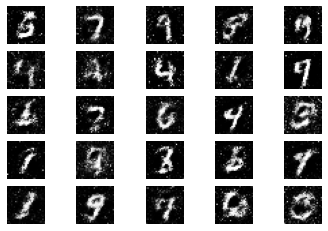

2601 [D loss: 0.635409, acc.: 64.84%] [G loss: 0.834678]
2602 [D loss: 0.614364, acc.: 70.70%] [G loss: 0.842187]
2603 [D loss: 0.633437, acc.: 64.45%] [G loss: 0.821225]
2604 [D loss: 0.649493, acc.: 63.28%] [G loss: 0.836237]
2605 [D loss: 0.678645, acc.: 58.59%] [G loss: 0.802772]
2606 [D loss: 0.640391, acc.: 64.06%] [G loss: 0.840458]
2607 [D loss: 0.642614, acc.: 65.62%] [G loss: 0.818768]
2608 [D loss: 0.643468, acc.: 67.58%] [G loss: 0.803901]
2609 [D loss: 0.631130, acc.: 66.02%] [G loss: 0.837888]
2610 [D loss: 0.674227, acc.: 55.86%] [G loss: 0.787179]
2611 [D loss: 0.664292, acc.: 61.72%] [G loss: 0.822594]
2612 [D loss: 0.650794, acc.: 60.55%] [G loss: 0.815652]
2613 [D loss: 0.628164, acc.: 67.97%] [G loss: 0.845005]
2614 [D loss: 0.649455, acc.: 66.41%] [G loss: 0.847522]
2615 [D loss: 0.647201, acc.: 60.16%] [G loss: 0.837858]
2616 [D loss: 0.647642, acc.: 65.62%] [G loss: 0.815061]
2617 [D loss: 0.652372, acc.: 60.55%] [G loss: 0.797792]
2618 [D loss: 0.647777, acc.: 6

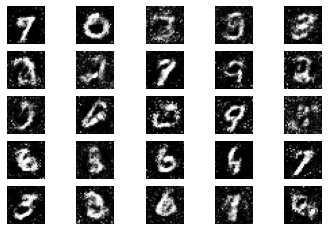

2801 [D loss: 0.640671, acc.: 66.02%] [G loss: 0.797264]
2802 [D loss: 0.652423, acc.: 63.67%] [G loss: 0.814460]
2803 [D loss: 0.622354, acc.: 68.75%] [G loss: 0.855678]
2804 [D loss: 0.647179, acc.: 63.67%] [G loss: 0.805974]
2805 [D loss: 0.655358, acc.: 63.67%] [G loss: 0.804447]
2806 [D loss: 0.637749, acc.: 62.11%] [G loss: 0.836603]
2807 [D loss: 0.647798, acc.: 63.28%] [G loss: 0.824138]
2808 [D loss: 0.644456, acc.: 64.84%] [G loss: 0.809343]
2809 [D loss: 0.640194, acc.: 63.28%] [G loss: 0.821590]
2810 [D loss: 0.625875, acc.: 65.23%] [G loss: 0.849009]
2811 [D loss: 0.650980, acc.: 63.67%] [G loss: 0.823217]
2812 [D loss: 0.649743, acc.: 64.06%] [G loss: 0.835922]
2813 [D loss: 0.630141, acc.: 64.45%] [G loss: 0.856254]
2814 [D loss: 0.648992, acc.: 63.67%] [G loss: 0.840442]
2815 [D loss: 0.649462, acc.: 64.45%] [G loss: 0.824839]
2816 [D loss: 0.631430, acc.: 66.80%] [G loss: 0.850519]
2817 [D loss: 0.646645, acc.: 66.02%] [G loss: 0.817704]
2818 [D loss: 0.659855, acc.: 6

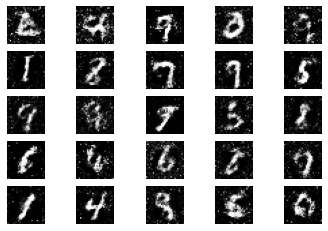

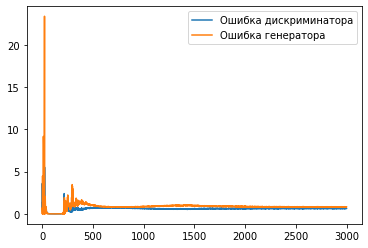

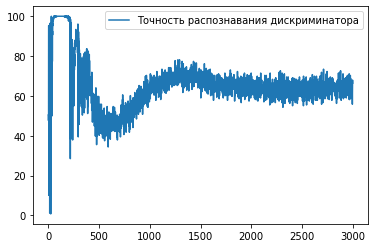

In [ ]:
generator_conv = create_conv_generator()
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator_conv, discriminator, 3000) # Вызываем функцию train  

# Обучение с разными batch_size для генератора и дискриминатора, попробуйте запустить с batch_size 128 для дискриминатора и 256 для генератора

1.Добавим переменную batch_size_gen = 256 для генератора

2.Создадим метки для генератора отдельно, batch_size_gen = 256

3.Внесем изменения в функцию train , т.к. в остальных функциях переменная batch_size не участвует

In [ ]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size
batch_size_gen = 256
optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [ ]:
def train(generator, discriminator, epochs=30000, batch_size=128, batch_size_gen = 256): # Функция обучения   
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size
  
  valid_gen = np.ones((batch_size_gen, 1)) # Создаем массив единиц длинной batch_size_gen
  fake_gen = np.zeros((batch_size_gen, 1)) # Создаем массив нулей длинной batch_size_gen

  z = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем выводить текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs): 
    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    imgs = X_train[idx] # В переменную imgs записываем значение из X_train с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений
    noise_gen = np.random.normal(0, 1, (batch_size_gen, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений

    gen_imgs = generator.predict(noise) # Предиктим картинку с помощью входной переменной generator
      
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = combined.train_on_batch(noise_gen, valid_gen) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))
    
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
        
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): 
        sample_images(epoch, generator) # Вызываем функцию sample_images для печати изображений
  
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

0 [D loss: 0.642435, acc.: 47.66%] [G loss: 0.513190]


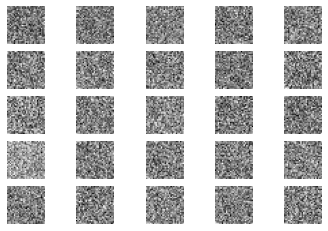

1 [D loss: 0.394358, acc.: 56.25%] [G loss: 0.494089]
2 [D loss: 0.359048, acc.: 72.27%] [G loss: 0.527146]
3 [D loss: 0.361082, acc.: 73.05%] [G loss: 0.582280]
4 [D loss: 0.344825, acc.: 78.52%] [G loss: 0.705523]
5 [D loss: 0.309148, acc.: 87.11%] [G loss: 0.769906]
6 [D loss: 0.286427, acc.: 90.23%] [G loss: 0.920354]
7 [D loss: 0.233462, acc.: 98.05%] [G loss: 1.089192]
8 [D loss: 0.201599, acc.: 99.22%] [G loss: 1.268453]
9 [D loss: 0.174831, acc.: 100.00%] [G loss: 1.450674]
10 [D loss: 0.149532, acc.: 99.61%] [G loss: 1.626869]
11 [D loss: 0.134466, acc.: 100.00%] [G loss: 1.760038]
12 [D loss: 0.105297, acc.: 100.00%] [G loss: 1.958054]
13 [D loss: 0.105750, acc.: 100.00%] [G loss: 2.055612]
14 [D loss: 0.090800, acc.: 100.00%] [G loss: 2.244210]
15 [D loss: 0.076443, acc.: 100.00%] [G loss: 2.379480]
16 [D loss: 0.071343, acc.: 100.00%] [G loss: 2.506322]
17 [D loss: 0.062552, acc.: 100.00%] [G loss: 2.537814]
18 [D loss: 0.061803, acc.: 100.00%] [G loss: 2.636191]
19 [D loss

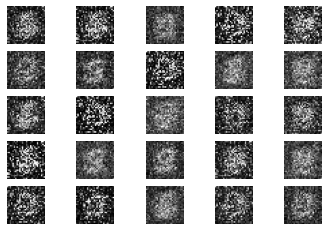

201 [D loss: 0.459299, acc.: 69.53%] [G loss: 1.839597]
202 [D loss: 0.625554, acc.: 56.25%] [G loss: 1.367265]
203 [D loss: 0.561775, acc.: 63.28%] [G loss: 1.536181]
204 [D loss: 0.626463, acc.: 56.25%] [G loss: 1.361314]
205 [D loss: 0.582806, acc.: 56.25%] [G loss: 1.421165]
206 [D loss: 0.773690, acc.: 39.84%] [G loss: 0.977987]
207 [D loss: 0.565173, acc.: 57.03%] [G loss: 1.471483]
208 [D loss: 1.019521, acc.: 28.52%] [G loss: 0.585738]
209 [D loss: 0.608378, acc.: 51.56%] [G loss: 1.115575]
210 [D loss: 0.748834, acc.: 39.06%] [G loss: 0.944935]
211 [D loss: 0.674587, acc.: 49.61%] [G loss: 1.015765]
212 [D loss: 0.756707, acc.: 42.58%] [G loss: 0.796551]
213 [D loss: 0.642867, acc.: 49.22%] [G loss: 0.978025]
214 [D loss: 0.727890, acc.: 42.19%] [G loss: 0.887906]
215 [D loss: 0.700521, acc.: 44.53%] [G loss: 0.851008]
216 [D loss: 0.770130, acc.: 39.84%] [G loss: 0.703448]
217 [D loss: 0.712153, acc.: 44.14%] [G loss: 0.809325]
218 [D loss: 0.737435, acc.: 40.62%] [G loss: 0.

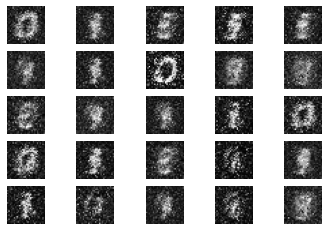

401 [D loss: 0.663161, acc.: 49.22%] [G loss: 0.650992]
402 [D loss: 0.657927, acc.: 50.00%] [G loss: 0.651284]
403 [D loss: 0.658872, acc.: 49.22%] [G loss: 0.653697]
404 [D loss: 0.661493, acc.: 48.05%] [G loss: 0.650349]
405 [D loss: 0.651372, acc.: 50.00%] [G loss: 0.648899]
406 [D loss: 0.664913, acc.: 49.61%] [G loss: 0.645103]
407 [D loss: 0.653198, acc.: 49.61%] [G loss: 0.649997]
408 [D loss: 0.653792, acc.: 50.00%] [G loss: 0.649812]
409 [D loss: 0.653261, acc.: 49.61%] [G loss: 0.652898]
410 [D loss: 0.651447, acc.: 49.22%] [G loss: 0.654465]
411 [D loss: 0.650807, acc.: 50.00%] [G loss: 0.655219]
412 [D loss: 0.653063, acc.: 48.83%] [G loss: 0.654031]
413 [D loss: 0.650324, acc.: 50.39%] [G loss: 0.659121]
414 [D loss: 0.649008, acc.: 49.22%] [G loss: 0.661175]
415 [D loss: 0.649656, acc.: 50.78%] [G loss: 0.659801]
416 [D loss: 0.665071, acc.: 49.22%] [G loss: 0.660096]
417 [D loss: 0.648732, acc.: 49.61%] [G loss: 0.657068]
418 [D loss: 0.650046, acc.: 48.83%] [G loss: 0.

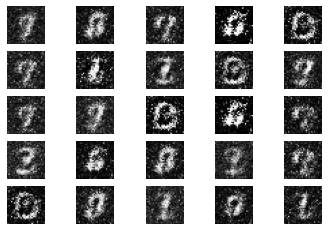

601 [D loss: 0.632608, acc.: 59.38%] [G loss: 0.732970]
602 [D loss: 0.645691, acc.: 55.86%] [G loss: 0.740383]
603 [D loss: 0.619554, acc.: 64.06%] [G loss: 0.746699]
604 [D loss: 0.637637, acc.: 59.38%] [G loss: 0.744115]
605 [D loss: 0.644348, acc.: 57.81%] [G loss: 0.735597]
606 [D loss: 0.637151, acc.: 61.33%] [G loss: 0.746025]
607 [D loss: 0.625457, acc.: 63.28%] [G loss: 0.754473]
608 [D loss: 0.640674, acc.: 63.67%] [G loss: 0.761545]
609 [D loss: 0.634967, acc.: 59.77%] [G loss: 0.775260]
610 [D loss: 0.641755, acc.: 60.94%] [G loss: 0.769272]
611 [D loss: 0.632761, acc.: 60.94%] [G loss: 0.770910]
612 [D loss: 0.658668, acc.: 57.42%] [G loss: 0.771022]
613 [D loss: 0.641738, acc.: 58.98%] [G loss: 0.775994]
614 [D loss: 0.654448, acc.: 54.30%] [G loss: 0.774659]
615 [D loss: 0.640263, acc.: 55.08%] [G loss: 0.767772]
616 [D loss: 0.639014, acc.: 58.59%] [G loss: 0.759490]
617 [D loss: 0.641805, acc.: 55.86%] [G loss: 0.754124]
618 [D loss: 0.636707, acc.: 57.42%] [G loss: 0.

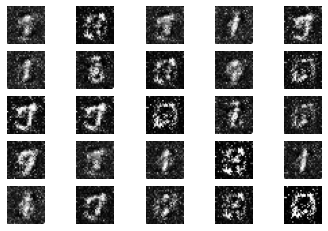

801 [D loss: 0.587936, acc.: 70.31%] [G loss: 0.899543]
802 [D loss: 0.584817, acc.: 71.09%] [G loss: 0.937754]
803 [D loss: 0.578845, acc.: 78.91%] [G loss: 0.936031]
804 [D loss: 0.587216, acc.: 75.39%] [G loss: 0.911598]
805 [D loss: 0.581904, acc.: 73.44%] [G loss: 0.904002]
806 [D loss: 0.593410, acc.: 75.00%] [G loss: 0.913380]
807 [D loss: 0.560740, acc.: 77.34%] [G loss: 0.924060]
808 [D loss: 0.577291, acc.: 76.17%] [G loss: 0.908190]
809 [D loss: 0.594885, acc.: 73.44%] [G loss: 0.918105]
810 [D loss: 0.595466, acc.: 70.70%] [G loss: 0.899368]
811 [D loss: 0.589940, acc.: 72.27%] [G loss: 0.906959]
812 [D loss: 0.582363, acc.: 76.95%] [G loss: 0.910848]
813 [D loss: 0.598983, acc.: 68.75%] [G loss: 0.921147]
814 [D loss: 0.580692, acc.: 78.91%] [G loss: 0.904339]
815 [D loss: 0.587752, acc.: 76.56%] [G loss: 0.910061]
816 [D loss: 0.590348, acc.: 77.34%] [G loss: 0.923860]
817 [D loss: 0.596640, acc.: 75.39%] [G loss: 0.915778]
818 [D loss: 0.606228, acc.: 66.80%] [G loss: 0.

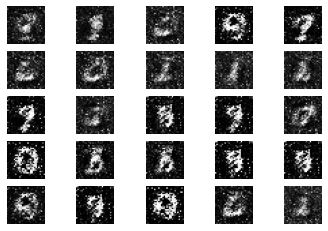

1001 [D loss: 0.591655, acc.: 67.97%] [G loss: 0.962008]
1002 [D loss: 0.539848, acc.: 77.34%] [G loss: 0.956121]
1003 [D loss: 0.568294, acc.: 69.53%] [G loss: 1.019134]
1004 [D loss: 0.569040, acc.: 73.83%] [G loss: 1.010887]
1005 [D loss: 0.576438, acc.: 72.66%] [G loss: 0.974218]
1006 [D loss: 0.563780, acc.: 74.22%] [G loss: 0.975043]
1007 [D loss: 0.527568, acc.: 79.30%] [G loss: 1.012970]
1008 [D loss: 0.560307, acc.: 77.73%] [G loss: 1.003442]
1009 [D loss: 0.600730, acc.: 69.53%] [G loss: 0.980534]
1010 [D loss: 0.561456, acc.: 76.95%] [G loss: 1.026197]
1011 [D loss: 0.571050, acc.: 73.83%] [G loss: 1.004193]
1012 [D loss: 0.568635, acc.: 73.05%] [G loss: 0.987435]
1013 [D loss: 0.567392, acc.: 74.22%] [G loss: 1.001903]
1014 [D loss: 0.552797, acc.: 79.69%] [G loss: 1.009504]
1015 [D loss: 0.550075, acc.: 74.61%] [G loss: 1.053784]
1016 [D loss: 0.545956, acc.: 84.38%] [G loss: 1.067409]
1017 [D loss: 0.533500, acc.: 83.98%] [G loss: 1.057692]
1018 [D loss: 0.558900, acc.: 7

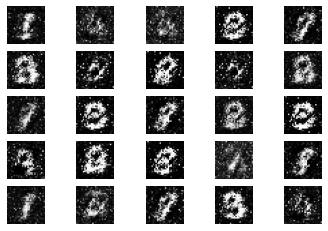

1201 [D loss: 0.565849, acc.: 75.39%] [G loss: 1.163925]
1202 [D loss: 0.578506, acc.: 73.44%] [G loss: 1.116477]
1203 [D loss: 0.557296, acc.: 77.73%] [G loss: 1.085330]
1204 [D loss: 0.545059, acc.: 78.52%] [G loss: 1.091534]
1205 [D loss: 0.538587, acc.: 77.73%] [G loss: 1.112296]
1206 [D loss: 0.563931, acc.: 75.78%] [G loss: 1.106367]
1207 [D loss: 0.562044, acc.: 75.78%] [G loss: 1.085445]
1208 [D loss: 0.575875, acc.: 71.48%] [G loss: 1.078828]
1209 [D loss: 0.561749, acc.: 75.00%] [G loss: 1.105110]
1210 [D loss: 0.539944, acc.: 81.25%] [G loss: 1.125145]
1211 [D loss: 0.556365, acc.: 81.64%] [G loss: 1.122906]
1212 [D loss: 0.524002, acc.: 83.98%] [G loss: 1.146621]
1213 [D loss: 0.522081, acc.: 83.20%] [G loss: 1.165514]
1214 [D loss: 0.547393, acc.: 78.52%] [G loss: 1.181967]
1215 [D loss: 0.527595, acc.: 85.55%] [G loss: 1.136088]
1216 [D loss: 0.521755, acc.: 84.38%] [G loss: 1.150596]
1217 [D loss: 0.577055, acc.: 79.30%] [G loss: 1.090590]
1218 [D loss: 0.558037, acc.: 7

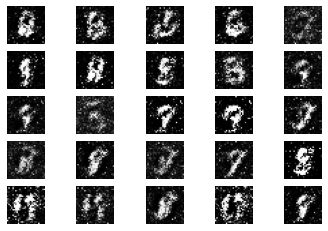

1401 [D loss: 0.548138, acc.: 74.61%] [G loss: 1.162987]
1402 [D loss: 0.547309, acc.: 77.34%] [G loss: 1.150745]
1403 [D loss: 0.533772, acc.: 78.91%] [G loss: 1.117103]
1404 [D loss: 0.520151, acc.: 78.52%] [G loss: 1.178329]
1405 [D loss: 0.561532, acc.: 73.83%] [G loss: 1.102839]
1406 [D loss: 0.526054, acc.: 80.08%] [G loss: 1.124338]
1407 [D loss: 0.555629, acc.: 72.66%] [G loss: 1.137046]
1408 [D loss: 0.512553, acc.: 84.77%] [G loss: 1.182296]
1409 [D loss: 0.531364, acc.: 78.52%] [G loss: 1.154485]
1410 [D loss: 0.540379, acc.: 78.91%] [G loss: 1.126420]
1411 [D loss: 0.579706, acc.: 70.70%] [G loss: 1.103825]
1412 [D loss: 0.521514, acc.: 80.08%] [G loss: 1.136348]
1413 [D loss: 0.530620, acc.: 79.30%] [G loss: 1.182362]
1414 [D loss: 0.566312, acc.: 74.61%] [G loss: 1.136711]
1415 [D loss: 0.552017, acc.: 80.86%] [G loss: 1.148734]
1416 [D loss: 0.551736, acc.: 77.73%] [G loss: 1.153243]
1417 [D loss: 0.569518, acc.: 72.66%] [G loss: 1.100315]
1418 [D loss: 0.536568, acc.: 7

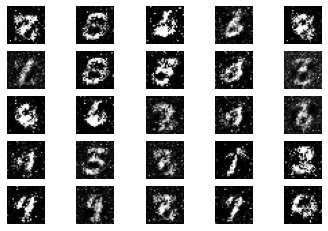

1601 [D loss: 0.510176, acc.: 82.42%] [G loss: 1.136155]
1602 [D loss: 0.506901, acc.: 81.25%] [G loss: 1.142743]
1603 [D loss: 0.563258, acc.: 69.53%] [G loss: 1.120798]
1604 [D loss: 0.505477, acc.: 81.25%] [G loss: 1.137292]
1605 [D loss: 0.553089, acc.: 75.00%] [G loss: 1.149389]
1606 [D loss: 0.549860, acc.: 73.05%] [G loss: 1.098991]
1607 [D loss: 0.514599, acc.: 77.73%] [G loss: 1.107478]
1608 [D loss: 0.515376, acc.: 80.08%] [G loss: 1.157416]
1609 [D loss: 0.570555, acc.: 69.53%] [G loss: 1.170406]
1610 [D loss: 0.543684, acc.: 77.73%] [G loss: 1.112842]
1611 [D loss: 0.537714, acc.: 77.73%] [G loss: 1.109433]
1612 [D loss: 0.499276, acc.: 83.59%] [G loss: 1.168403]
1613 [D loss: 0.570688, acc.: 72.66%] [G loss: 1.133748]
1614 [D loss: 0.576510, acc.: 69.53%] [G loss: 1.102498]
1615 [D loss: 0.525665, acc.: 78.91%] [G loss: 1.137475]
1616 [D loss: 0.554512, acc.: 71.09%] [G loss: 1.190195]
1617 [D loss: 0.565782, acc.: 77.73%] [G loss: 1.148782]
1618 [D loss: 0.540422, acc.: 7

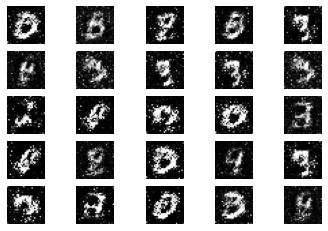

1801 [D loss: 0.544006, acc.: 77.34%] [G loss: 1.129905]
1802 [D loss: 0.554168, acc.: 74.61%] [G loss: 1.155335]
1803 [D loss: 0.555837, acc.: 73.83%] [G loss: 1.172429]
1804 [D loss: 0.556131, acc.: 71.09%] [G loss: 1.147596]
1805 [D loss: 0.572698, acc.: 71.88%] [G loss: 1.062220]
1806 [D loss: 0.550039, acc.: 70.70%] [G loss: 1.212509]
1807 [D loss: 0.542219, acc.: 74.22%] [G loss: 1.235060]
1808 [D loss: 0.520758, acc.: 75.00%] [G loss: 1.288630]
1809 [D loss: 0.553035, acc.: 75.00%] [G loss: 1.153688]
1810 [D loss: 0.573322, acc.: 66.80%] [G loss: 1.090761]
1811 [D loss: 0.528893, acc.: 76.17%] [G loss: 1.169308]
1812 [D loss: 0.501223, acc.: 79.69%] [G loss: 1.237994]
1813 [D loss: 0.543082, acc.: 73.44%] [G loss: 1.246255]
1814 [D loss: 0.496282, acc.: 79.30%] [G loss: 1.252766]
1815 [D loss: 0.544276, acc.: 73.83%] [G loss: 1.219802]
1816 [D loss: 0.542728, acc.: 73.44%] [G loss: 1.213462]
1817 [D loss: 0.535260, acc.: 73.44%] [G loss: 1.224710]
1818 [D loss: 0.536132, acc.: 7

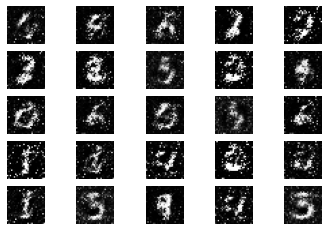

2001 [D loss: 0.515604, acc.: 80.08%] [G loss: 1.252872]
2002 [D loss: 0.534288, acc.: 78.52%] [G loss: 1.188077]
2003 [D loss: 0.523210, acc.: 80.47%] [G loss: 1.183020]
2004 [D loss: 0.516843, acc.: 79.30%] [G loss: 1.178510]
2005 [D loss: 0.505849, acc.: 79.69%] [G loss: 1.194007]
2006 [D loss: 0.483357, acc.: 85.94%] [G loss: 1.217736]
2007 [D loss: 0.459785, acc.: 87.89%] [G loss: 1.313329]
2008 [D loss: 0.510897, acc.: 79.69%] [G loss: 1.228935]
2009 [D loss: 0.498184, acc.: 78.91%] [G loss: 1.284136]
2010 [D loss: 0.467614, acc.: 87.11%] [G loss: 1.264456]
2011 [D loss: 0.466906, acc.: 84.38%] [G loss: 1.223248]
2012 [D loss: 0.485510, acc.: 82.81%] [G loss: 1.261653]
2013 [D loss: 0.508320, acc.: 77.34%] [G loss: 1.241161]
2014 [D loss: 0.473963, acc.: 81.25%] [G loss: 1.223394]
2015 [D loss: 0.487359, acc.: 83.98%] [G loss: 1.222449]
2016 [D loss: 0.516610, acc.: 79.69%] [G loss: 1.246391]
2017 [D loss: 0.465765, acc.: 83.98%] [G loss: 1.290129]
2018 [D loss: 0.507999, acc.: 7

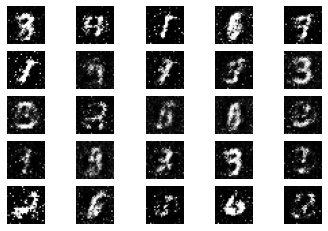

2201 [D loss: 0.505348, acc.: 80.08%] [G loss: 1.209840]
2202 [D loss: 0.521473, acc.: 76.95%] [G loss: 1.219330]
2203 [D loss: 0.500488, acc.: 81.64%] [G loss: 1.227559]
2204 [D loss: 0.499679, acc.: 80.08%] [G loss: 1.213243]
2205 [D loss: 0.538003, acc.: 73.44%] [G loss: 1.218573]
2206 [D loss: 0.513413, acc.: 81.64%] [G loss: 1.177415]
2207 [D loss: 0.521259, acc.: 77.34%] [G loss: 1.176067]
2208 [D loss: 0.508998, acc.: 79.69%] [G loss: 1.219052]
2209 [D loss: 0.545161, acc.: 78.12%] [G loss: 1.178272]
2210 [D loss: 0.537905, acc.: 73.44%] [G loss: 1.226156]
2211 [D loss: 0.565867, acc.: 72.27%] [G loss: 1.192156]
2212 [D loss: 0.526019, acc.: 76.95%] [G loss: 1.207126]
2213 [D loss: 0.534740, acc.: 76.56%] [G loss: 1.249537]
2214 [D loss: 0.494130, acc.: 80.08%] [G loss: 1.264590]
2215 [D loss: 0.552066, acc.: 73.44%] [G loss: 1.286944]
2216 [D loss: 0.532375, acc.: 74.61%] [G loss: 1.277326]
2217 [D loss: 0.540722, acc.: 76.17%] [G loss: 1.192260]
2218 [D loss: 0.514131, acc.: 7

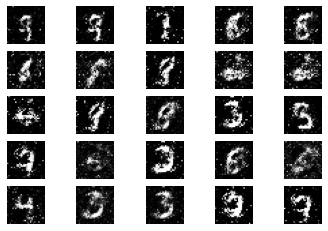

2401 [D loss: 0.543061, acc.: 71.09%] [G loss: 1.176482]
2402 [D loss: 0.514027, acc.: 76.95%] [G loss: 1.246383]
2403 [D loss: 0.506433, acc.: 76.17%] [G loss: 1.245868]
2404 [D loss: 0.571059, acc.: 71.88%] [G loss: 1.273509]
2405 [D loss: 0.493396, acc.: 77.73%] [G loss: 1.298623]
2406 [D loss: 0.601345, acc.: 64.45%] [G loss: 1.250991]
2407 [D loss: 0.521153, acc.: 75.78%] [G loss: 1.316996]
2408 [D loss: 0.537224, acc.: 76.95%] [G loss: 1.250837]
2409 [D loss: 0.520681, acc.: 77.34%] [G loss: 1.283651]
2410 [D loss: 0.530785, acc.: 71.88%] [G loss: 1.260641]
2411 [D loss: 0.511629, acc.: 78.52%] [G loss: 1.212418]
2412 [D loss: 0.544133, acc.: 71.48%] [G loss: 1.206122]
2413 [D loss: 0.516698, acc.: 76.95%] [G loss: 1.245229]
2414 [D loss: 0.535709, acc.: 73.83%] [G loss: 1.294898]
2415 [D loss: 0.501474, acc.: 78.91%] [G loss: 1.355811]
2416 [D loss: 0.517863, acc.: 80.47%] [G loss: 1.308224]
2417 [D loss: 0.506948, acc.: 78.12%] [G loss: 1.250469]
2418 [D loss: 0.527019, acc.: 7

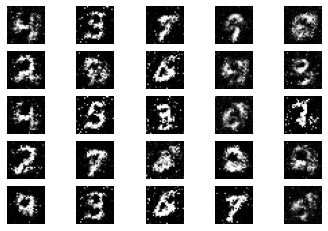

2601 [D loss: 0.508827, acc.: 79.30%] [G loss: 1.257160]
2602 [D loss: 0.536247, acc.: 75.00%] [G loss: 1.267954]
2603 [D loss: 0.508237, acc.: 77.34%] [G loss: 1.234575]
2604 [D loss: 0.552085, acc.: 70.70%] [G loss: 1.164919]
2605 [D loss: 0.512995, acc.: 74.61%] [G loss: 1.173435]
2606 [D loss: 0.503948, acc.: 78.52%] [G loss: 1.244997]
2607 [D loss: 0.511816, acc.: 77.73%] [G loss: 1.301525]
2608 [D loss: 0.510197, acc.: 76.56%] [G loss: 1.272802]
2609 [D loss: 0.525739, acc.: 77.73%] [G loss: 1.250695]
2610 [D loss: 0.576540, acc.: 69.53%] [G loss: 1.189260]
2611 [D loss: 0.487656, acc.: 80.47%] [G loss: 1.286883]
2612 [D loss: 0.496565, acc.: 80.08%] [G loss: 1.345998]
2613 [D loss: 0.535655, acc.: 76.95%] [G loss: 1.267949]
2614 [D loss: 0.493314, acc.: 80.47%] [G loss: 1.248582]
2615 [D loss: 0.469982, acc.: 83.20%] [G loss: 1.266709]
2616 [D loss: 0.492865, acc.: 80.86%] [G loss: 1.307635]
2617 [D loss: 0.506595, acc.: 82.42%] [G loss: 1.259022]
2618 [D loss: 0.542597, acc.: 7

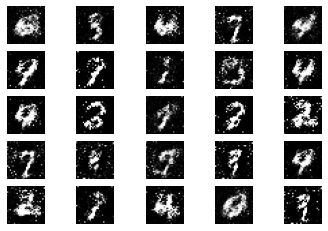

2801 [D loss: 0.508427, acc.: 77.34%] [G loss: 1.328388]
2802 [D loss: 0.492413, acc.: 82.03%] [G loss: 1.398294]
2803 [D loss: 0.487151, acc.: 82.42%] [G loss: 1.341853]
2804 [D loss: 0.474575, acc.: 81.25%] [G loss: 1.332240]
2805 [D loss: 0.496515, acc.: 78.52%] [G loss: 1.320843]
2806 [D loss: 0.487670, acc.: 84.77%] [G loss: 1.326006]
2807 [D loss: 0.484480, acc.: 78.52%] [G loss: 1.423855]
2808 [D loss: 0.497273, acc.: 78.52%] [G loss: 1.378115]
2809 [D loss: 0.529745, acc.: 77.73%] [G loss: 1.323377]
2810 [D loss: 0.486662, acc.: 82.42%] [G loss: 1.362267]
2811 [D loss: 0.487902, acc.: 82.81%] [G loss: 1.332808]
2812 [D loss: 0.498056, acc.: 80.08%] [G loss: 1.273727]
2813 [D loss: 0.475616, acc.: 82.03%] [G loss: 1.316763]
2814 [D loss: 0.520277, acc.: 75.39%] [G loss: 1.327775]
2815 [D loss: 0.484112, acc.: 82.03%] [G loss: 1.360873]
2816 [D loss: 0.536929, acc.: 78.52%] [G loss: 1.318352]
2817 [D loss: 0.479476, acc.: 78.91%] [G loss: 1.344940]
2818 [D loss: 0.423645, acc.: 8

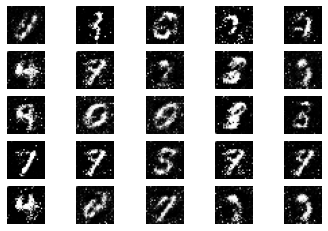

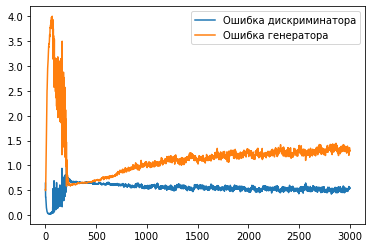

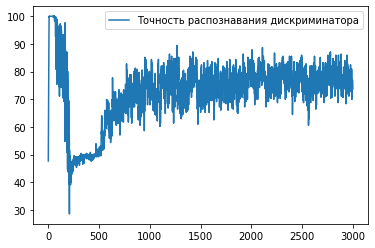

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 3000) # Вызываем функцию train с параметрами, generator, discriminator, 3000 (3000 - количество эпох)

Результат при одинаковом batch_size = 128 на генераторе и дискриминаторе:  2999 [D loss: 0.616632, acc.: 69.14%] [G loss: 0.893976]

Результат при разных batch_size (на генераторе = 256, на дискриминаторе = 128): 2999 [D loss: 0.548405, acc.: 73.83%] [G loss: 1.298287]


Вывод: В случае с одинаковыми батчами модель отрадотала визуально лучше , ошибка на генераторе меньше при batch_size = 128.